## **Analisis PESOS - TEA Shanusi**

In [1]:
import pandas as pd # Dataframes
import numpy as np # Arreglos y matrices
import scipy.stats as stats 
import matplotlib.pyplot as plt # Graficos
import seaborn as sns  # para análisis gráficos
import random # para generar aleatorios

### 0. Funciones

In [2]:
## FUNCION COMPLETITUD
## #######################
## #######################
## #######################

def function_completitud(df_x, variable, valor = 2, anio_filtro = '1901-01-01'):
    # Mostrando estadísticas importantes

    # --- Seleccionamos PLANTACION
    # ---
    df_bbdd_imputar = df_x
    plantacion_name = df_bbdd_imputar['PLANTACION'].unique()

    # Crear una nueva columna con el año y mes en el formato deseado
    df_bbdd_imputar['FECHA'] = pd.to_datetime(df_bbdd_imputar['FECHA'])

    # Crear un rango de fechas que cubra el período completo del DataFrame original
    start_date = df_bbdd_imputar['FECHA'].min().replace(day=1)
    end_date = (df_bbdd_imputar['FECHA'].max() + pd.offsets.MonthEnd(1)).replace(day=1) - pd.Timedelta(days=1)
    all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

    # Crear un DataFrame con todas las fechas
    df_all_dates = pd.DataFrame(all_dates, columns=['FECHA'])
    # Hacer un merge con el DataFrame original
    df_merged = pd.merge(df_all_dates, df_bbdd_imputar, on='FECHA', how='left')

    # Filtramos el año si es que fuera necesario
    # ---
    # Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16
    fecha_limite = pd.Timestamp(anio_filtro)
    df_merged = df_merged[df_merged['FECHA'] > fecha_limite]

    # Crear las columnas variable_con_datos y variable_sin_datos
    df_merged['variable_con_datos'] = np.where(df_merged[variable].notnull() & (df_merged[variable] != 0), 1, 0)
    df_merged['variable_sin_datos'] = np.where(df_merged[variable].isnull() | (df_merged[variable] == 0), 1, 0)

    # Agrupar por mes y sumar las columnas
    df_merged['AÑO_MES'] = df_merged['FECHA'].dt.strftime('%Y-%m')
    df_monthly = df_merged.groupby('AÑO_MES').agg({'variable_con_datos': 'sum', 'variable_sin_datos': 'sum'}).reset_index()
    df_monthly['PLANTACION'] = plantacion_name[0]
    df_monthly['Total_dias'] = df_monthly['variable_con_datos'] + df_monthly['variable_sin_datos']
    df_monthly['% Completitud'] = df_monthly['variable_con_datos']/(df_monthly['variable_con_datos'] + df_monthly['variable_sin_datos'])

    # Agrupar por año
    df_merged['AÑO'] = df_merged['FECHA'].dt.strftime('%Y')
    df_year = df_merged.groupby('AÑO').agg({'variable_con_datos': 'sum', 'variable_sin_datos': 'sum'}).reset_index()
    df_year['PLANTACION'] = plantacion_name[0]
    df_year['Total_dias'] = df_year['variable_con_datos'] + df_year['variable_sin_datos']
    df_year['% Completitud'] = df_year['variable_con_datos']/(df_year['variable_con_datos'] + df_year['variable_sin_datos'])

    # Creando el indicador divergencia KL (Kullback-Leibler)
    # ------
    df_merged['incompleto'] = df_merged[variable]
    df_merged['completo'] = df_merged[variable]

    # Reemplazamos los ceros por NaN

    df_merged['completo'].replace(0, np.nan, inplace=True)
    df_merged['completo'].fillna(method='ffill', inplace=True) # Reemplazamos los valores NaN por el valor anterior (forward fill)

    # Calcular la moda de cada columna
    # moda_variable = df_merged['completo'].mode().iloc[0]

    # Verificar si la moda no está vacía antes de acceder al primer elemento
    if not df_merged['completo'].mode().empty:
        moda_variable = df_merged['completo'].mode().iloc[0]
        df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por la moda
    else:
        # Si no hay moda, calcular el promedio
        moda_variable = df_merged['completo'].mean()
        df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por el promedio


    df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por el valor anterior (forward fill)

    # Calcular las distribuciones de la variable original y la imputada
    hist_original, bin_edges = np.histogram(df_merged['incompleto'].dropna(), bins=30, density=True)
    hist_imputado, _ = np.histogram(df_merged['completo'], bins=bin_edges, density=True)

    # Calcular la divergencia KL entre las dos distribuciones
    kl_divergence = entropy(hist_original, hist_imputado)


    # Guardamos el datframe - df_monthly
    # -----
    print( "## ################# ##")
    print(f'Divergencia KL: {kl_divergence}')
    print(f'Dataframe creados: df_year, df_month')
    print( "## ################# ##")

    # Especifica la ruta donde deseas guardar el excel
    ruta_missing_mensual =  '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/missing_values/df_missing_values_month.xlsx'  # Cambia esta ruta a la que necesites
    df_monthly.to_excel(ruta_path + ruta_missing_mensual, index=False)
    print(f'Datos guardados en {ruta_path + ruta_missing_mensual}')

    # Guardamos el datframe - df_year
    # -----
    # Especifica la ruta donde deseas guardar el excel
    ruta_missing_anual =  '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/missing_values/df_missing_values_year.xlsx'  # Cambia esta ruta a la que necesites
    df_year.to_excel(ruta_path + ruta_missing_anual, index=False)
    print(f'Datos guardados en {ruta_path + ruta_missing_anual}')

     # Mostrar el DataFrame correspondiente según el valor de `val`
    if valor == 1:
        print("DataFrame df_year:")
        print(df_year.head(10))
    else:
        print("DataFrame df_month:")
        print(df_monthly.head(10))



## FUNCION COMPLETITUD PENALIZADA
## #######################
## #######################
## #######################

def function_completitud_pen(df_x, variable, valor = 2, anio_filtro = '1901-01-01'):
    # Mostrando estadísticas importantes

    # --- Seleccionamos PLANTACION
    # ---
    df_bbdd_imputar = df_x
    plantacion_name = df_bbdd_imputar['PLANTACION'].unique()

    # Crear una nueva columna con el año y mes en el formato deseado
    df_bbdd_imputar['FECHA'] = pd.to_datetime(df_bbdd_imputar['FECHA'])

    # Crear un rango de fechas que cubra el período completo del DataFrame original
    start_date = df_bbdd_imputar['FECHA'].min().replace(day=1)
    end_date = (df_bbdd_imputar['FECHA'].max() + pd.offsets.MonthEnd(1)).replace(day=1) - pd.Timedelta(days=1)
    all_dates = pd.date_range(start=start_date, end=end_date, freq='D')

    # Crear un DataFrame con todas las fechas
    df_all_dates = pd.DataFrame(all_dates, columns=['FECHA'])
    # Hacer un merge con el DataFrame original
    df_merged = pd.merge(df_all_dates, df_bbdd_imputar, on='FECHA', how='left')
    df_merged['FECHA'] = pd.to_datetime(df_merged['FECHA'])
    dim_start = df_merged.shape[0]

    # Filtrar filas donde el día de la semana no sea domingo (domingo es 6)
    df_merged = df_merged[df_merged['FECHA'].dt.weekday != 6]
    df_merged = df_merged[df_merged['FECHA'].dt.weekday != 5]

    dim_finish = df_merged.shape[0]

    dim_reduccion = dim_finish/dim_start

    # Filtramos el año si es que fuera necesario
    # ---
    # Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16
    fecha_limite = pd.Timestamp(anio_filtro)
    df_merged = df_merged[df_merged['FECHA'] > fecha_limite]

    # Crear las columnas variable_con_datos y variable_sin_datos
    df_merged['variable_con_datos'] = np.where(df_merged[variable].notnull() & (df_merged[variable] != 0), 1, 0)
    df_merged['variable_sin_datos'] = np.where(df_merged[variable].isnull() | (df_merged[variable] == 0), 1, 0)

    sum_variable_con_datos = df_merged['variable_con_datos'].sum()
    sum_variable_sin_datos = df_merged['variable_sin_datos'].sum()
    pctj_completitud_total = sum_variable_con_datos/(sum_variable_con_datos + sum_variable_sin_datos)

    # Agrupar por mes y sumar las columnas
    df_merged['AÑO_MES'] = df_merged['FECHA'].dt.strftime('%Y-%m')
    df_monthly = df_merged.groupby('AÑO_MES').agg({'variable_con_datos': 'sum', 'variable_sin_datos': 'sum'}).reset_index()
    df_monthly['PLANTACION'] = plantacion_name[0]
    df_monthly['Total_dias'] = df_monthly['variable_con_datos'] + df_monthly['variable_sin_datos']
    df_monthly['% Completitud'] = df_monthly['variable_con_datos']/(df_monthly['variable_con_datos'] + df_monthly['variable_sin_datos'])

    # Agrupar por año
    df_merged['AÑO'] = df_merged['FECHA'].dt.strftime('%Y')
    df_year = df_merged.groupby('AÑO').agg({'variable_con_datos': 'sum', 'variable_sin_datos': 'sum'}).reset_index()
    df_year['PLANTACION'] = plantacion_name[0]
    df_year['Total_dias'] = df_year['variable_con_datos'] + df_year['variable_sin_datos']
    df_year['% Completitud'] = df_year['variable_con_datos']/(df_year['variable_con_datos'] + df_year['variable_sin_datos'])

    # Creando el indicador divergencia KL (Kullback-Leibler)
    # ------
    df_merged['incompleto'] = df_merged[variable]
    df_merged['completo'] = df_merged[variable]

    # Reemplazamos los ceros por NaN

    df_merged['completo'].replace(0, np.nan, inplace=True)
    df_merged['completo'].fillna(method='ffill', inplace=True) # Reemplazamos los valores NaN por el valor anterior (forward fill)

    # Calcular la moda de cada columna
    # moda_variable = df_merged['completo'].mode().iloc[0]

    # Verificar si la moda no está vacía antes de acceder al primer elemento
    if not df_merged['completo'].mode().empty:
        moda_variable = df_merged['completo'].mode().iloc[0]
        df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por la moda
    else:
        # Si no hay moda, calcular el promedio
        moda_variable = df_merged['completo'].mean()
        df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por el promedio


    df_merged['completo'] = df_merged['completo'].fillna(moda_variable) # Reemplazamos los valores NaN por el valor anterior (forward fill)

    # Calcular las distribuciones de la variable original y la imputada
    hist_original, bin_edges = np.histogram(df_merged['incompleto'].dropna(), bins=30, density=True)
    hist_imputado, _ = np.histogram(df_merged['completo'], bins=bin_edges, density=True)

    # Calcular la divergencia KL entre las dos distribuciones
    kl_divergence = entropy(hist_original, hist_imputado)


    # Guardamos el datframe - df_monthly
    # -----
    print( "## ################# ##")
    print(f'Divergencia KL: {kl_divergence}')
    print(f'Sin considerar dias sábados/domingos: {dim_reduccion}')
    print(f'Dataframe creados: df_year, df_month')
    print(f'pctj_completitud_total= {pctj_completitud_total}')
    print( "## ################# ##")

    # Especifica la ruta donde deseas guardar el excel
    ruta_missing_mensual =  '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/missing_values/df_missing_values_month.xlsx'  # Cambia esta ruta a la que necesites
    df_monthly.to_excel(ruta_path + ruta_missing_mensual, index=False)
    print(f'Datos guardados en {ruta_path + ruta_missing_mensual}')

    # Guardamos el datframe - df_year
    # -----
    # Especifica la ruta donde deseas guardar el excel
    ruta_missing_anual =  '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/missing_values/df_missing_values_year.xlsx'  # Cambia esta ruta a la que necesites
    df_year.to_excel(ruta_path + ruta_missing_anual, index=False)
    print(f'Datos guardados en {ruta_path + ruta_missing_anual}')

     # Mostrar el DataFrame correspondiente según el valor de `val`
    if valor == 1:
        print("DataFrame df_year:")
        print(df_year.head(10))
    else:
        print("DataFrame df_month:")
        print(df_monthly.head(10))






## FUNCION GRAFICADORA 1
## #######################
## #######################
## #######################

def function_tendencia_unica(df_x, valor,colors='green'):
    df_x = df_x.sort_values(by='FECHA')
    plantacion_name = df_x['PLANTACION'].unique()

    # Si solo te interesa modificar el primer valor (o un único valor) puedes hacer:
    if 'Shanuzi' in plantacion_name:
        plantacion_name = ['Shanuzi']
    else:
        plantacion_name = plantacion_name.tolist()
    
    plt.figure(figsize=(15, 5))
    plt.plot(df_x['FECHA'], df_x[valor], marker='o', markersize=2, linestyle='-', color=colors, label='Pesos')
    # plt.title(f'{plantacion_name[0]}: variable {valor} - a través del Tiempo ')
    plt.title(f'variable {valor} - a través del Tiempo ')
   
    plt.xlabel('Fecha')
    plt.ylabel('Pesos')
    plt.grid(True)
    plt.legend()
    #plt.xticks(rotation=45)

    fecha_min = df_x['FECHA'].min()
    fecha_max = df_x['FECHA'].max()
    print('Analisis de ', fecha_min, ' hasta ', fecha_max)
    
    # Mostrar la gráfica
    # print(df_TEA_full_tendencia[df_TEA_full_tendencia['RFF PROCESADO'] == 0].head())
    plt.tight_layout()
    plt.show()




## FUNCION CORRELACION CRUZADA
## #######################
## #######################
## #######################

def correlacion_cruzada(serie1, serie2):
    lags = np.arange(-len(serie1) + 1, len(serie1))
    corr = [serie1.corr(serie2.shift(lag)) for lag in lags]
    return lags, corr





## FUNCION SAVE EXCEL
## #######################
## #######################
## #######################

def function_save(df_x):
    # Especifica la ruta donde deseas guardar el CSV
    ruta_save =  '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/__bbdd_revision__.xlsx'  # Cambia esta ruta a la que necesites
    df_x.to_excel(ruta_path + ruta_save, index=False)
    print(f'Datos guardados en {ruta_path + ruta_save}')



## FUNCION IMPUTACION OUTLIER
## #######################
## #######################
## #######################

def imputar_valores_extremos(df, variable, metodo='media'):
    """
    Imputa valores extremos en una variable de un DataFrame utilizando la media o la mediana.

    Parámetros:
    df (DataFrame): El DataFrame que contiene la variable a imputar.
    variable (str): El nombre de la variable que deseas imputar.
    metodo (str): La forma de imputación ('media' o 'mediana'). Por defecto es 'media'.

    Retorna:
    DataFrame: El DataFrame con la variable imputada.
    """
    if metodo not in ['media', 'mediana']:
        raise ValueError("El método debe ser 'media' o 'mediana'")

    # Calcular la media o la mediana
    if metodo == 'media':
        valor_imputacion = df[variable].mean()
    else:
        valor_imputacion = df[variable].median()

    # Identificar valores extremos (usando una regla de 3 veces la desviación estándar)
    limite_inferior = df[variable].mean() - 3 * df[variable].std()
    limite_superior = df[variable].mean() + 3 * df[variable].std()

    # Imputar valores extremos
    df[variable] = np.where(
        (df[variable] < limite_inferior) | (df[variable] > limite_superior),
        valor_imputacion,
        df[variable]
    )

    return df



In [ ]:
# pip install scikit-learn

### 1. Carga de datos

In [4]:
# Cargamos el archivo Excel - RFF Procesado
# --------------

ruta_path = 'C:/cesar_quezada/ProyectosIA/Proyectos_PALMAS'               # -> Casa
# ruta_path = 'C:/Users/usuario/Documents/DOCUMENTOS_CONSULTOR_5_BI'      # -> Trabajo


ruta_path_fabrica = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_sabana_fabrica_full.csv'
ruta_path_balanza = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_sabana_participacion_full.csv'
ruta_path_saldo_campo = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_sabana_saldo_campo_full_vf.csv'
ruta_calidad_precipitacion = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_calidad_precipitacion_full.csv'
# --
ruta_calidad_racimos_propios = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_calidad_racimos_propios_total_full.csv'
ruta_antiguedad_frutos = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_antiguedad_fruta_full.csv'
# --
ruta_calidad_racimos_terceros = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_sabana_calidad_terceros_full.csv'
# --
ruta_acidez = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_acidez_full.csv'
# --
ruta_clima = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_clima_full_vf.csv'
# --
ruta__freq_cosecha = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_freq_cosecha_full.csv'
# --
ruta_participacion_cashcost_full = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_participacion_cashcost_full.csv'
# --
ruta_perdida_aceite_full = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_perdida_aceite_full.csv'
# --
ruta_perdida_cosecha = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_perdida_otros_full_group.csv'

# --
ruta_polinizadores_pw = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_polinizadores_pw.csv'
ruta_polinizadores_sh = '/PROYECTO_01_analitica_descriptiva_TEA/data/processed/df_polinizadores_sh.csv'


In [5]:
### Cargamos df_sabana_fabrica_full
### --------------------
df_sabana_fabrica_full = pd.read_csv(ruta_path + ruta_path_fabrica)
df_sabana_balanza_full = pd.read_csv(ruta_path + ruta_path_balanza)

df_sabana_saldo_campo_full_vf = pd.read_csv(ruta_path + ruta_path_saldo_campo)
df_sabana_saldo_campo_full_vf['FECHA'] = pd.to_datetime(df_sabana_saldo_campo_full_vf['FECHA'])

df_calidad_precipitacion_full = pd.read_csv(ruta_path + ruta_calidad_precipitacion)
df_calidad_precipitacion_full['FECHA'] = df_calidad_precipitacion_full['FECHA'].str.split(' ').str[0]
df_calidad_precipitacion_full['FECHA'] = pd.to_datetime(df_calidad_precipitacion_full['FECHA'], format='%Y-%m-%d')

# --
df_calidad_racimos_propios_full = pd.read_csv(ruta_path + ruta_calidad_racimos_propios)
df_calidad_antiguedad_frutos_full = pd.read_csv(ruta_path + ruta_antiguedad_frutos)

# --
df_sabana_calidad_terceros_full = pd.read_csv(ruta_path + ruta_calidad_racimos_terceros)
df_sabana_calidad_terceros_full['FECHA'] = pd.to_datetime(df_sabana_calidad_terceros_full['FECHA'], format='%Y-%m-%d')
df_sabana_calidad_terceros_full['% VERDES'] = df_sabana_calidad_terceros_full['% VERDES'].replace('-',np.nan)
df_sabana_calidad_terceros_full['% MADUROS'] = df_sabana_calidad_terceros_full['% MADUROS'].replace('-',np.nan)
df_sabana_calidad_terceros_full['% SMADUROS'] = df_sabana_calidad_terceros_full['% SMADUROS'].replace('-',np.nan)
df_sabana_calidad_terceros_full['% ESCOBAJO'] = df_sabana_calidad_terceros_full['% ESCOBAJO'].replace('-',np.nan)

df_sabana_calidad_terceros_full['% VERDES'] = df_sabana_calidad_terceros_full['% VERDES'].astype(float)
df_sabana_calidad_terceros_full['% MADUROS'] = df_sabana_calidad_terceros_full['% MADUROS'].astype(float)
df_sabana_calidad_terceros_full['% SMADUROS'] = df_sabana_calidad_terceros_full['% SMADUROS'].astype(float)
df_sabana_calidad_terceros_full['% ESCOBAJO'] = df_sabana_calidad_terceros_full['% ESCOBAJO'].astype(float)

# --
df_acidez_full = pd.read_csv(ruta_path + ruta_acidez)

# --
df_clima_full_vf = pd.read_csv(ruta_path + ruta_clima)

# --
df_freq_cosecha_full = pd.read_csv(ruta_path + ruta__freq_cosecha)

# --
df_participacion_cashcost_full = pd.read_csv(ruta_path + ruta_participacion_cashcost_full)

# --
df_perdida_aceite_full = pd.read_csv(ruta_path + ruta_perdida_aceite_full,sep = ';')
df_perdida_aceite_full['FECHA'] = pd.to_datetime(df_perdida_aceite_full['FECHA'], format='%d/%m/%Y')

# --
df_perdida_cosecha_full_vf = pd.read_csv(ruta_path + ruta_perdida_cosecha)

# --
# --
df_polinizadores_full_pw = pd.read_csv(ruta_path + ruta_polinizadores_pw, encoding='latin-1',sep = ';')
# --
df_polinizadores_full_sh = pd.read_csv(ruta_path + ruta_polinizadores_sh, encoding='latin-1',sep = ';')
df_polinizadores_full_sh.columns = ['Año', 'Mes', 'Mes_txt', 'PLANTACION', 'NumInsectos','PromInsectosFlor', 'PromInsectosHa']

# Standarizando datos
# ----
df_polinizadores_full_sh['PromInsectosFlor'] = df_polinizadores_full_sh['PromInsectosFlor']/1000
df_polinizadores_full_sh['PromInsectosHa'] = df_polinizadores_full_sh['PromInsectosHa']/1000

# Concatenando datos
# -----
# Concatenar los DataFrames
df_polinizadores_full = pd.concat([df_polinizadores_full_pw, df_polinizadores_full_sh], ignore_index=True)
# Crear la columna 'FECHA' combinando 'año','mes','dia'
df_polinizadores_full['Dia'] = 1 # Agregar una columna de 'día' con un valor predeterminado (por ejemplo, 1)
df_polinizadores_full.rename(columns={'Año': 'year', 'Mes': 'month', 'Dia': 'day'}, inplace=True) # Renombrar las columnas para que pandas las reconozca correctamente
df_polinizadores_full['FECHA'] = pd.to_datetime(df_polinizadores_full[['year', 'month', 'day']]) # Crear la columna 'FECHA' combinando 'year', 'month' y 'day'


### 2. Construyendo DataFrame consolidado

In [6]:
# Limpiando variables faltantes con peso en balanza


# -----------
# -------
# ---
# sede_analisis = 'Palmawasi'
sede_analisis = 'Shanuzi'
# sede_analisis = 'Nuevo Horizonte'
# sede_analisis = 'Tulumayo'


# -------
# ---


#### TEA propios vs terceros

In [7]:
df_participacion_cashcost_full['FECHA'] = pd.to_datetime(df_participacion_cashcost_full['FECHA'])
df_analisis_tendencia =  df_participacion_cashcost_full[df_participacion_cashcost_full['PLANTACION'] == sede_analisis]
df_analisis_tendencia.head()

,pk_tiempo,vch_centro,SEDE,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenido,CPOObtenidoPropios,CPOObtenidoTerceros,FECHA,PLANTACION
3,20190102,3702,SH,109.94,102.72,7.22,24.56,24.06793,0.49207,2019-01-02,Shanuzi
6,20190103,3702,SH,673.98,652.58,21.40,167.02,163.67371,3.34629,2019-01-03,Shanuzi
9,20190104,3702,SH,1075.50,1054.55,20.95,272.28,266.82479,5.45521,2019-01-04,Shanuzi
12,20190105,3702,SH,508.95,494.13,14.82,150.43,147.41609,3.01391,2019-01-05,Shanuzi
15,20190106,3702,SH,0.00,0.00,0.00,0.00,0.00000,0.00000,2019-01-06,Shanuzi


In [8]:
## REDUCIENDO LA BASE A SEMANA
## --------
## --------

# Crear columna 'SEMANA'
df_analisis_tendencia['SEMANA'] = df_analisis_tendencia['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)

# Agrupar por 'SEMANA' calcular la suma de valores
# ------------------------
df_analisis_tendencia_semana = df_analisis_tendencia.groupby(['SEMANA','PLANTACION']).agg({'RFFProcesado': 'sum',
                                                                                           'RFFProcesadoPropios':'sum',
                                                                                           'RFFProcesadoTerceros':'sum',
                                                                                           'CPOObtenidoPropios':'sum',
                                                                                           'CPOObtenidoTerceros':'sum',
                                                                                           'CPOObtenido': 'sum'}).reset_index()
df_analisis_tendencia_semana.columns = ['FECHA','PLANTACION', 'RFFProcesado', 'RFFProcesadoPropios','RFFProcesadoTerceros', 'CPOObtenidoPropios', 'CPOObtenidoTerceros','CPOObtenido']
df_analisis_tendencia_semana['TEA_total'] = df_analisis_tendencia_semana['CPOObtenido']/df_analisis_tendencia_semana['RFFProcesado']
df_analisis_tendencia_semana['TEA_propios'] = df_analisis_tendencia_semana['CPOObtenidoPropios']/df_analisis_tendencia_semana['RFFProcesadoPropios']
df_analisis_tendencia_semana['TEA_terceros'] = df_analisis_tendencia_semana['CPOObtenidoTerceros']/df_analisis_tendencia_semana['RFFProcesadoTerceros']
df_analisis_tendencia_semana.head()

C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_21584\224845057.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia['SEMANA'] = df_analisis_tendencia['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)


,FECHA,PLANTACION,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenidoPropios,CPOObtenidoTerceros,CPOObtenido,TEA_total,TEA_propios,TEA_terceros
0,2018-12-31,Shanuzi,2368.37,2303.98,64.39,601.98252,12.30748,614.290,0.259372,0.261279,0.191140
1,2019-01-07,Shanuzi,3617.40,3519.19,98.21,885.45594,18.10306,903.559,0.249781,0.251608,0.184330
2,2019-01-14,Shanuzi,4440.89,4372.67,68.22,1065.01782,21.77418,1086.792,0.244724,0.243562,0.319176
3,2019-01-21,Shanuzi,4561.70,4500.33,61.37,1122.30852,22.94548,1145.254,0.251059,0.249384,0.373888
4,2019-01-28,Shanuzi,4127.80,4040.07,87.73,1040.12030,16.32270,1056.443,0.255934,0.257451,0.186056


In [ ]:
df_analisis_tendencia_semana.columns

In [9]:
columns_tea = ['FECHA','PLANTACION','TEA_total','RFFProcesado','RFFProcesadoPropios','RFFProcesadoTerceros','CPOObtenido']
df_tea_propios_terceros = df_analisis_tendencia_semana[columns_tea]
df_tea_propios_terceros.head()


,FECHA,PLANTACION,TEA_total,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenido
0,2018-12-31,Shanuzi,0.259372,2368.37,2303.98,64.39,614.290
1,2019-01-07,Shanuzi,0.249781,3617.40,3519.19,98.21,903.559
2,2019-01-14,Shanuzi,0.244724,4440.89,4372.67,68.22,1086.792
3,2019-01-21,Shanuzi,0.251059,4561.70,4500.33,61.37,1145.254
4,2019-01-28,Shanuzi,0.255934,4127.80,4040.07,87.73,1056.443


#### Calidad de Racimos Propios

In [10]:
# Completando datos con Peso balanza de Propios y terceros
# ----
df_sabana_balanza_full['FECHA'] = pd.to_datetime(df_sabana_balanza_full['FECHA'])
df_calidad_racimos_propios_full['FECHA'] = pd.to_datetime(df_calidad_racimos_propios_full['FECHA'])
df_calidad_racimos_propios_full.head()

,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos
0,2021-08-18,Palmawasi,55.0,1978.0,62.0,0.0,0.0,45.0,5.0,NaN,NaN
1,2021-08-19,Palmawasi,91.0,2100.0,91.0,0.0,0.0,89.0,9.0,NaN,NaN
2,2021-08-20,Palmawasi,49.0,1776.0,78.0,9.0,0.0,52.0,6.0,NaN,NaN
3,2021-08-21,Palmawasi,35.0,2033.0,113.0,0.0,0.0,62.0,4.0,NaN,NaN
4,2021-08-23,Palmawasi,43.0,1288.0,121.0,0.0,0.0,41.0,3.0,NaN,NaN


In [11]:
print(f'dimension inicial: {df_calidad_racimos_propios_full.shape}')

df_calidad_racimos_propios_full_v2 = pd.merge(df_calidad_racimos_propios_full,
                                              df_sabana_balanza_full[['FECHA','PLANTACION','PROPIOS']],
                                              on = ['FECHA','PLANTACION'],
                                              how = 'outer')

df_calidad_racimos_propios_full_v2['FECHA'] = pd.to_datetime(df_calidad_racimos_propios_full_v2['FECHA'])
df_calidad_racimos_propios_full_v2['Peso_propios'] = df_calidad_racimos_propios_full_v2['PROPIOS']*1000
df_calidad_racimos_propios_full_v2['PCTJ'] = df_calidad_racimos_propios_full_v2['Peso']/df_calidad_racimos_propios_full_v2['Peso_propios']
# Reemplazar valores 'inf' con NaN
df_calidad_racimos_propios_full_v2['PCTJ'].replace([np.inf, -np.inf], np.nan, inplace=True)

print(f'dimension final: {df_calidad_racimos_propios_full_v2.shape}')
df_calidad_racimos_propios_full_v2.head()

dimension inicial: (2362, 11)
dimension final: (6186, 14)


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_21584\381160290.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_calidad_racimos_propios_full_v2['PCTJ'].replace([np.inf, -np.inf], np.nan, inplace=True)


,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos,PROPIOS,Peso_propios,PCTJ
0,2020-01-02,Nuevo Horizonte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.78,26780.0,NaN
1,2020-01-02,Palmawasi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,625.66,625660.0,NaN
2,2020-01-02,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,639.73,639730.0,NaN
3,2020-01-02,Tulumayo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,639.73,639730.0,NaN
4,2020-01-03,Nuevo Horizonte,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.21,36210.0,NaN


In [12]:
# --------
# ---

min_fecha_balanza = df_sabana_balanza_full[df_sabana_balanza_full['PLANTACION'] == sede_analisis].FECHA.min()
min_fecha_racimos = df_calidad_racimos_propios_full[df_calidad_racimos_propios_full['PLANTACION'] == sede_analisis].FECHA.min()

print(f'df_sabana_balanza_full: {min_fecha_balanza}')
print(f'df_calidad_racimos_propios_full {min_fecha_racimos}')

df_calidad_racimos_propios_filter = df_calidad_racimos_propios_full_v2[df_calidad_racimos_propios_full_v2['PLANTACION'] == sede_analisis]
df_calidad_racimos_propios_filter['FECHA'] = pd.to_datetime(df_calidad_racimos_propios_filter['FECHA'])

print(df_calidad_racimos_propios_filter.PLANTACION.unique())
df_calidad_racimos_propios_filter.head()

df_sabana_balanza_full: 2020-01-02 00:00:00
df_calidad_racimos_propios_full 2022-01-03 00:00:00
['Shanuzi']


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_21584\175372827.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_calidad_racimos_propios_filter['FECHA'] = pd.to_datetime(df_calidad_racimos_propios_filter['FECHA'])


,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos,PROPIOS,Peso_propios,PCTJ
2,2020-01-02,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,639.73,639730.0,NaN
6,2020-01-03,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.13,14130.0,NaN
10,2020-01-04,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.45,450.0,NaN
15,2020-01-06,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,306.67,306670.0,NaN
18,2020-01-07,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,640.60,640600.0,NaN


In [13]:
# Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16
# fecha_limite = pd.Timestamp('2021-08-18') ## --> Para sede Palmawasi
fecha_limite = pd.Timestamp('2022-01-03') ## --> Para sede Shanuzi
# fecha_limite = pd.Timestamp('2020-01-03') ## --> Para sede Tulumayo
# fecha_limite = pd.Timestamp('2020-01-02') ## --> Para sede Nuevo Horizonte

df_filtrado =  df_calidad_racimos_propios_filter[df_calidad_racimos_propios_filter['FECHA'] >= fecha_limite]
df_filtrado.head()

,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos,PROPIOS,Peso_propios,PCTJ
2639,2022-01-03,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.400986e+05,55872.0,879.12,879120.0,0.386863
2643,2022-01-04,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.082831e+06,71622.0,1145.79,1145790.0,0.945052
2647,2022-01-05,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.017149e+06,74650.0,1151.49,1151490.0,0.883333
2651,2022-01-06,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.095006e+06,74774.0,1173.62,1173620.0,0.933015
2655,2022-01-07,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.608574e+05,60555.0,922.93,922930.0,0.932744


In [14]:
# Completando porcentajes faltanes
# -------
# Crear una nueva columna 'AÑO' que contenga solo el año
df_filtrado['AÑO'] = df_filtrado['FECHA'].dt.year

print(df_filtrado.groupby('AÑO').agg({'Peso':'sum'}).reset_index())
resumen_pctj = df_filtrado.groupby('AÑO').agg({'PCTJ':'mean'}).reset_index()
resumen_pctj.columns = ['AÑO','PCTJ_AÑO']

# -------------
# resumen_pctj.iloc[0,1] = 0.966405 ## --> Para Palmawasi
# resumen_pctj['PCTJ_AÑO'] = 1 ## --> Tulumayo
# -------------
print('---------------------')
print(resumen_pctj)

    AÑO          Peso
0  2022  2.837949e+08
1  2023  2.819689e+08
2  2024  9.834929e+07
---------------------
    AÑO  PCTJ_AÑO
0  2022  1.011472
1  2023  1.016670
2  2024  1.228475


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_21584\2804392279.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['AÑO'] = df_filtrado['FECHA'].dt.year


In [15]:
df_filtrado = pd.merge(df_filtrado,
                       resumen_pctj,
                       on = 'AÑO',
                       how = 'left')
df_filtrado.head()

,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos,PROPIOS,Peso_propios,PCTJ,AÑO,PCTJ_AÑO
0,2022-01-03,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.400986e+05,55872.0,879.12,879120.0,0.386863,2022,1.011472
1,2022-01-04,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.082831e+06,71622.0,1145.79,1145790.0,0.945052,2022,1.011472
2,2022-01-05,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.017149e+06,74650.0,1151.49,1151490.0,0.883333,2022,1.011472
3,2022-01-06,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.095006e+06,74774.0,1173.62,1173620.0,0.933015,2022,1.011472
4,2022-01-07,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.608574e+05,60555.0,922.93,922930.0,0.932744,2022,1.011472


In [17]:
# Crear la nueva columna 'Peso_ajustado'
df_filtrado['Peso_ajustado'] = np.where(df_filtrado['Peso'].isna(), df_filtrado['Peso_propios'] * df_filtrado['PCTJ_AÑO'], df_filtrado['Peso'])
df_filtrado.head()


,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,PEDUNCULO,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Racimos,PROPIOS,Peso_propios,PCTJ,AÑO,PCTJ_AÑO,Peso_ajustado
0,2022-01-03,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.400986e+05,55872.0,879.12,879120.0,0.386863,2022,1.011472,3.400986e+05
1,2022-01-04,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.082831e+06,71622.0,1145.79,1145790.0,0.945052,2022,1.011472,1.082831e+06
2,2022-01-05,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.017149e+06,74650.0,1151.49,1151490.0,0.883333,2022,1.011472,1.017149e+06
3,2022-01-06,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.095006e+06,74774.0,1173.62,1173620.0,0.933015,2022,1.011472,1.095006e+06
4,2022-01-07,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.608574e+05,60555.0,922.93,922930.0,0.932744,2022,1.011472,8.608574e+05


In [18]:
## REDUCIENDO LA BASE A SEMANA
## ############
## ############

df_analisis_tendencia_2 = df_filtrado
df_analisis_tendencia_2['FECHA'] = pd.to_datetime(df_analisis_tendencia_2['FECHA'])

# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_tendencia_2['SEMANA'] = df_analisis_tendencia_2['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)

# ----------
df_analisis_tendencia_semana_2 = df_analisis_tendencia_2.groupby(['SEMANA','PLANTACION']).agg({'VERDES':'sum',
                                                                                               'MADUROS':'sum',
                                                                                               'SMADUROS':'sum',
                                                                                               'ESCOBAJO':'sum',
                                                                                               'MALFORMADOA':'sum',
                                                                                               'MALFORMADOB':'sum',
                                                                                               'Peso': 'sum',
                                                                                               'Peso_ajustado':'sum',
                                                                                               'Racimos':'sum',
                                                                                               'Peso_propios':'sum'}).reset_index()

df_analisis_tendencia_semana_2.columns = ['FECHA', 'PLANTACION', 'VERDES', 'MADUROS', 'SMADUROS', 'ESCOBAJO','MALFORMADOA','MALFORMADOB','Peso','Peso_ajustado','Racimos','Peso_propios']

df_analisis_tendencia_semana_2.head()


,FECHA,PLANTACION,VERDES,MADUROS,SMADUROS,ESCOBAJO,MALFORMADOA,MALFORMADOB,Peso,Peso_ajustado,Racimos,Peso_propios
0,2022-01-03,Shanuzi,0.0,0.0,0.0,0.0,0.0,0.0,4.451012e+06,4.451012e+06,341051.0,5332570.0
1,2022-01-10,Shanuzi,0.0,0.0,0.0,0.0,0.0,0.0,5.039059e+06,5.078891e+06,350212.0,5452880.0
2,2022-01-17,Shanuzi,0.0,0.0,0.0,0.0,0.0,0.0,6.533269e+06,6.533269e+06,449793.0,6294980.0
3,2022-01-24,Shanuzi,0.0,0.0,0.0,0.0,0.0,0.0,5.390967e+06,5.390967e+06,373554.0,5640920.0
4,2022-01-31,Shanuzi,0.0,0.0,0.0,0.0,0.0,0.0,5.702007e+06,5.702007e+06,297405.0,4469380.0


In [19]:
# Creando variables de calidad
# ----

# VARIABLES CALIDAD SEMANAL
# -------
# ---
df_analisis_tendencia_semana_2['Peso_CALIDAD'] = df_analisis_tendencia_semana_2[['VERDES','MADUROS','SMADUROS','ESCOBAJO']].sum(axis=1)

df_analisis_tendencia_semana_2['%_VERDES'] = df_analisis_tendencia_semana_2['VERDES']/ df_analisis_tendencia_semana_2['Peso_CALIDAD']
df_analisis_tendencia_semana_2['%_MADUROS'] = df_analisis_tendencia_semana_2['MADUROS']/ df_analisis_tendencia_semana_2['Peso_CALIDAD']
df_analisis_tendencia_semana_2['%_SMADUROS'] = df_analisis_tendencia_semana_2['SMADUROS']/ df_analisis_tendencia_semana_2['Peso_CALIDAD']
df_analisis_tendencia_semana_2['%_ESCOBAJO'] = df_analisis_tendencia_semana_2['ESCOBAJO']/ df_analisis_tendencia_semana_2['Peso_CALIDAD']
df_analisis_tendencia_semana_2['%_MALFORMADOA'] = df_analisis_tendencia_semana_2['MALFORMADOA']/ df_analisis_tendencia_semana_2['Peso_CALIDAD']
df_analisis_tendencia_semana_2['%_MALFORMADOB'] = df_analisis_tendencia_semana_2['MALFORMADOB']/ df_analisis_tendencia_semana_2['Peso_CALIDAD']


df_analisis_tendencia_semana_2['Peso_VERDES'] = df_analisis_tendencia_semana_2['Peso_ajustado']*(df_analisis_tendencia_semana_2['VERDES']/ df_analisis_tendencia_semana_2['Peso_CALIDAD'])
df_analisis_tendencia_semana_2['Peso_MADUROS'] = df_analisis_tendencia_semana_2['Peso_ajustado']*(df_analisis_tendencia_semana_2['MADUROS']/ df_analisis_tendencia_semana_2['Peso_CALIDAD'])
df_analisis_tendencia_semana_2['Peso_SMADUROS'] = df_analisis_tendencia_semana_2['Peso_ajustado']*(df_analisis_tendencia_semana_2['SMADUROS']/ df_analisis_tendencia_semana_2['Peso_CALIDAD'])
df_analisis_tendencia_semana_2['Peso_ESCOBAJO'] = df_analisis_tendencia_semana_2['Peso_ajustado']*(df_analisis_tendencia_semana_2['ESCOBAJO']/ df_analisis_tendencia_semana_2['Peso_CALIDAD'])
df_analisis_tendencia_semana_2['Peso_MALFORMADOA'] = df_analisis_tendencia_semana_2['Peso_ajustado']*(df_analisis_tendencia_semana_2['MALFORMADOA']/ df_analisis_tendencia_semana_2['Peso_CALIDAD'])
df_analisis_tendencia_semana_2['Peso_MALFORMADOB'] = df_analisis_tendencia_semana_2['Peso_ajustado']*(df_analisis_tendencia_semana_2['MALFORMADOB']/ df_analisis_tendencia_semana_2['Peso_CALIDAD'])

df_analisis_tendencia_semana_2['FECHA'] = pd.to_datetime(df_analisis_tendencia_semana_2['FECHA'])


In [ ]:
df_analisis_tendencia_semana_2.tail()

In [ ]:
df_analisis_tendencia_semana_2.columns

In [20]:
# Creando df de Calidad Racimos Propios
# -----

columns_rac_propios = ['FECHA', 'PLANTACION','Peso_VERDES','Peso_MADUROS', 'Peso_SMADUROS', 'Peso_ESCOBAJO', 'Peso_MALFORMADOA','Peso_MALFORMADOB']

df_racimos_propios = df_analisis_tendencia_semana_2[columns_rac_propios]
df_racimos_propios.columns = ['FECHA', 'PLANTACION','Peso_VERDES_propios','Peso_MADUROS_propios', 'Peso_SMADUROS_propios', 'Peso_ESCOBAJO_propios', 'Peso_MALFORMADOA_propios','Peso_MALFORMADOB_propios']

df_racimos_propios.tail()

,FECHA,PLANTACION,Peso_VERDES_propios,Peso_MADUROS_propios,Peso_SMADUROS_propios,Peso_ESCOBAJO_propios,Peso_MALFORMADOA_propios,Peso_MALFORMADOB_propios
126,2024-06-03,Shanuzi,1624.200252,3.211206e+06,272540.802354,66592.210349,113044.337568,31834.324947
127,2024-06-10,Shanuzi,6711.009797,3.268911e+06,252637.046223,84212.348741,121880.597278,24029.744756
128,2024-06-17,Shanuzi,2769.332748,3.277399e+06,198113.804313,58369.013314,121424.589741,29184.506657
129,2024-06-24,Shanuzi,3893.723879,2.702028e+06,185600.838235,33096.652972,144067.783525,31798.745012
130,2024-07-01,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN


#### Calidad de Racimos Terceros

In [21]:
df_sabana_calidad_terceros_full['FECHA'] = pd.to_datetime(df_sabana_calidad_terceros_full['FECHA'])
df_sabana_calidad_terceros_full.head()

,AÑO,MES,FECHA,PESO NETO T.M.,% VERDES,% MADUROS,% SMADUROS,% ESCOBAJO,TOTAL,FRUTO SUELTO K.G.,% IMPUREZAS,% PEDUNCULO,% MALFORMADO,PLANTACION
0,2024,Enero,2024-01-02,119.10,0.001538,0.899231,0.099231,0.000000,1,0.0,0.0,0.003846153846153846,0.005384615384615384,Palmawasi
1,2024,Enero,2024-01-03,127.62,0.002914,0.901321,0.093629,0.002137,1,0.0,0.0,0.003496503496503497,0.008352758352758352,Palmawasi
2,2024,Enero,2024-01-04,199.01,0.005461,0.912969,0.080546,0.001024,1,0.0,0.0,0.005460750853242321,0.01023890784982935,Palmawasi
3,2024,Enero,2024-01-05,155.34,0.004018,0.900000,0.094866,0.001116,1,0.0,0.0,0.003348214285714286,0.0078125,Palmawasi
4,2024,Enero,2024-01-06,204.82,0.004518,0.904367,0.089910,0.001205,1,0.0,0.0,0.004518072289156626,0.008433734939759036,Palmawasi


In [22]:
print(f'dimension inicial: {df_sabana_calidad_terceros_full.shape}')

df_calidad_racimos_terceros_full_v2 = pd.merge(df_sabana_calidad_terceros_full,
                                               df_sabana_balanza_full[['FECHA','PLANTACION','TERCEROS']],
                                               on = ['FECHA','PLANTACION'],
                                               how = 'outer')

df_calidad_racimos_terceros_full_v2['FECHA'] = pd.to_datetime(df_calidad_racimos_terceros_full_v2['FECHA'])
df_calidad_racimos_terceros_full_v2['Peso_terceros'] = df_calidad_racimos_terceros_full_v2['TERCEROS']*1000

df_calidad_racimos_terceros_full_v2['PCTJ'] = (df_calidad_racimos_terceros_full_v2['PESO NETO T.M.']*1000)/df_calidad_racimos_terceros_full_v2['Peso_terceros']
# Reemplazar valores 'inf' con NaN
df_calidad_racimos_terceros_full_v2['PCTJ'].replace([np.inf, -np.inf], np.nan, inplace=True)
df_calidad_racimos_terceros_full_v2['% MALFORMADO'].replace('-', np.nan, inplace=True)
df_calidad_racimos_terceros_full_v2['% MALFORMADO'] = df_calidad_racimos_terceros_full_v2['% MALFORMADO'].astype('float')

print(f'dimension final: {df_calidad_racimos_terceros_full_v2.shape}')
df_calidad_racimos_terceros_full_v2.head()

dimension inicial: (2874, 14)
dimension final: (6309, 17)


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_21584\2638733628.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_calidad_racimos_terceros_full_v2['PCTJ'].replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_21584\2638733628.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on 

,AÑO,MES,FECHA,PESO NETO T.M.,% VERDES,% MADUROS,% SMADUROS,% ESCOBAJO,TOTAL,FRUTO SUELTO K.G.,% IMPUREZAS,% PEDUNCULO,% MALFORMADO,PLANTACION,TERCEROS,Peso_terceros,PCTJ
0,NaN,NaN,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nuevo Horizonte,0.0,0.0,NaN
1,NaN,NaN,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Palmawasi,0.0,0.0,NaN
2,NaN,NaN,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN
3,NaN,NaN,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tulumayo,0.0,0.0,NaN
4,NaN,NaN,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nuevo Horizonte,0.0,0.0,NaN


In [23]:
# Seleccionando la sede para pronosticar
# --------------

min_fecha_balanza = df_sabana_balanza_full[df_sabana_balanza_full['PLANTACION'] == sede_analisis].FECHA.min()
min_fecha_racimos = df_sabana_calidad_terceros_full[df_sabana_calidad_terceros_full['PLANTACION'] == sede_analisis].FECHA.min()

print(f'df_sabana_balanza_full: {min_fecha_balanza}')
print(f'df_calidad_racimos_propios_full {min_fecha_racimos}')

df_calidad_racimos_terceros_filter = df_calidad_racimos_terceros_full_v2[df_calidad_racimos_terceros_full_v2['PLANTACION'] == sede_analisis]
df_calidad_racimos_terceros_filter['FECHA'] = pd.to_datetime(df_calidad_racimos_terceros_filter['FECHA'])

print(df_calidad_racimos_terceros_filter.PLANTACION.unique())
df_calidad_racimos_terceros_filter.head()


df_sabana_balanza_full: 2020-01-02 00:00:00
df_calidad_racimos_propios_full 2022-01-03 00:00:00
['Shanuzi']


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_21584\3025376969.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_calidad_racimos_terceros_filter['FECHA'] = pd.to_datetime(df_calidad_racimos_terceros_filter['FECHA'])


,AÑO,MES,FECHA,PESO NETO T.M.,% VERDES,% MADUROS,% SMADUROS,% ESCOBAJO,TOTAL,FRUTO SUELTO K.G.,% IMPUREZAS,% PEDUNCULO,% MALFORMADO,PLANTACION,TERCEROS,Peso_terceros,PCTJ
2,NaN,NaN,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN
6,NaN,NaN,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN
10,NaN,NaN,2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN
15,NaN,NaN,2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN
18,NaN,NaN,2020-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN


In [24]:
# Filtrar el DataFrame para considerar solo las fechas mayores a 2023-03-16

fecha_limite = pd.Timestamp('2020-01-02') ## --> Para sede shanusi
# fecha_limite = pd.Timestamp('2020-01-03') ## --> Para sede Tulumayo
# fecha_limite = pd.Timestamp('2020-01-02') ## --> Para sede Nuevo Horizonte

df_filtrado =  df_calidad_racimos_terceros_filter[df_calidad_racimos_terceros_filter['FECHA'] >= fecha_limite]
df_filtrado.head()

,AÑO,MES,FECHA,PESO NETO T.M.,% VERDES,% MADUROS,% SMADUROS,% ESCOBAJO,TOTAL,FRUTO SUELTO K.G.,% IMPUREZAS,% PEDUNCULO,% MALFORMADO,PLANTACION,TERCEROS,Peso_terceros,PCTJ
2,NaN,NaN,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN
6,NaN,NaN,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN
10,NaN,NaN,2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN
15,NaN,NaN,2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN
18,NaN,NaN,2020-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN


In [26]:
# Completando porcentajes faltanes
# -------
# Crear una nueva columna 'AÑO' que contenga solo el año
df_filtrado['AÑO'] = df_filtrado['FECHA'].dt.year

print(df_filtrado.groupby('AÑO').agg({'PESO NETO T.M.':'sum'}).reset_index())
resumen_pctj = df_filtrado.groupby('AÑO').agg({'PCTJ':'mean'}).reset_index()
resumen_pctj.columns = ['AÑO','PCTJ_AÑO']

# -------------
# resumen_pctj.iloc[0,1] = 0.966405 ## --> Para Palmawasi
# resumen_pctj['PCTJ_AÑO'] = 1 ## --> Tulumayo
# -------------
print('---------------------')
print(resumen_pctj)


    AÑO  PESO NETO T.M.
0  2020            0.00
1  2021            0.00
2  2022        21544.52
3  2023        26737.06
4  2024        17948.81
---------------------
    AÑO  PCTJ_AÑO
0  2020       NaN
1  2021       NaN
2  2022  0.951024
3  2023  0.992659
4  2024  0.752511


In [27]:
df_filtrado = pd.merge(df_filtrado,
                       resumen_pctj,
                       on = 'AÑO',
                       how = 'left')
df_filtrado.head()

,AÑO,MES,FECHA,PESO NETO T.M.,% VERDES,% MADUROS,% SMADUROS,% ESCOBAJO,TOTAL,FRUTO SUELTO K.G.,% IMPUREZAS,% PEDUNCULO,% MALFORMADO,PLANTACION,TERCEROS,Peso_terceros,PCTJ,PCTJ_AÑO
0,2020,NaN,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN,NaN
1,2020,NaN,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN,NaN
2,2020,NaN,2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN,NaN
3,2020,NaN,2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN,NaN
4,2020,NaN,2020-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN,NaN


In [28]:
# Crear la nueva columna 'Peso_ajustado'
df_filtrado['Peso_ajustado'] = np.where(df_filtrado['PESO NETO T.M.'].isna(), df_filtrado['Peso_terceros'] * df_filtrado['PCTJ_AÑO'], df_filtrado['PESO NETO T.M.']*1000)
df_filtrado.head()

,AÑO,MES,FECHA,PESO NETO T.M.,% VERDES,% MADUROS,% SMADUROS,% ESCOBAJO,TOTAL,FRUTO SUELTO K.G.,% IMPUREZAS,% PEDUNCULO,% MALFORMADO,PLANTACION,TERCEROS,Peso_terceros,PCTJ,PCTJ_AÑO,Peso_ajustado
0,2020,NaN,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN,NaN,NaN
1,2020,NaN,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN,NaN,NaN
2,2020,NaN,2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN,NaN,NaN
3,2020,NaN,2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN,NaN,NaN
4,2020,NaN,2020-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Shanuzi,0.0,0.0,NaN,NaN,NaN


In [29]:
## REDUCIENDO LA BASE A SEMANA Y MES
## ############

df_analisis_tendencia_3 = df_filtrado
df_analisis_tendencia_3['FECHA'] = pd.to_datetime(df_analisis_tendencia_3['FECHA'])

# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_tendencia_3['SEMANA'] = df_analisis_tendencia_3['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)

In [30]:
# VARIABLES CALIDAD MES
# -------
# ---

# VARIABLES CALIDAD SEMANAL
# -------
# ---
df_analisis_tendencia_3['Peso_VERDES'] = df_analisis_tendencia_3['Peso_ajustado']*(df_analisis_tendencia_3['% VERDES'])
df_analisis_tendencia_3['Peso_MADUROS'] = df_analisis_tendencia_3['Peso_ajustado']*(df_analisis_tendencia_3['% MADUROS'])
df_analisis_tendencia_3['Peso_SMADUROS'] = df_analisis_tendencia_3['Peso_ajustado']*(df_analisis_tendencia_3['% SMADUROS'])
df_analisis_tendencia_3['Peso_ESCOBAJO'] = df_analisis_tendencia_3['Peso_ajustado']*(df_analisis_tendencia_3['% ESCOBAJO'])
df_analisis_tendencia_3['Peso_MALFORMADO'] = df_analisis_tendencia_3['Peso_ajustado']*(df_analisis_tendencia_3['% MALFORMADO'])

df_analisis_tendencia_3['FECHA'] = pd.to_datetime(df_analisis_tendencia_3['FECHA'])
df_analisis_tendencia_3.head()


,AÑO,MES,FECHA,PESO NETO T.M.,% VERDES,% MADUROS,% SMADUROS,% ESCOBAJO,TOTAL,FRUTO SUELTO K.G.,...,Peso_terceros,PCTJ,PCTJ_AÑO,Peso_ajustado,SEMANA,Peso_VERDES,Peso_MADUROS,Peso_SMADUROS,Peso_ESCOBAJO,Peso_MALFORMADO
0,2020,NaN,2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,2019-12-30,NaN,NaN,NaN,NaN,NaN
1,2020,NaN,2020-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,2019-12-30,NaN,NaN,NaN,NaN,NaN
2,2020,NaN,2020-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,2019-12-30,NaN,NaN,NaN,NaN,NaN
3,2020,NaN,2020-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,2020-01-06,NaN,NaN,NaN,NaN,NaN
4,2020,NaN,2020-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,2020-01-06,NaN,NaN,NaN,NaN,NaN


In [31]:
# Agrupar por 'SEMANA' calcular la suma de valores
# ------------------------
# -----------------
# ----------
df_analisis_tendencia_semana_3 = df_analisis_tendencia_3.groupby(['SEMANA','PLANTACION']).agg({'Peso_VERDES':'sum',
                                                                                               'Peso_MADUROS':'sum',
                                                                                               'Peso_SMADUROS':'sum',
                                                                                               'Peso_ESCOBAJO':'sum',
                                                                                               'Peso_MALFORMADO':'sum',
                                                                                               'PESO NETO T.M.': 'sum',
                                                                                               'Peso_ajustado':'sum',
                                                                                               'Peso_terceros':'sum'}).reset_index()

df_analisis_tendencia_semana_3.columns = ['FECHA', 'PLANTACION', 'Peso_VERDES', 'Peso_MADUROS', 'Peso_SMADUROS','Peso_ESCOBAJO', 'Peso_MALFORMADO', 'PESO NETO T.M.', 'Peso_ajustado','Peso_terceros']


In [32]:
df_analisis_tendencia_semana_3.head()

,FECHA,PLANTACION,Peso_VERDES,Peso_MADUROS,Peso_SMADUROS,Peso_ESCOBAJO,Peso_MALFORMADO,PESO NETO T.M.,Peso_ajustado,Peso_terceros
0,2019-12-30,Shanuzi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-06,Shanuzi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-13,Shanuzi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-20,Shanuzi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-27,Shanuzi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
# Creando df de Calidad Racimos Terceros
# -----

columns_rac_terceros = ['FECHA', 'PLANTACION', 'Peso_VERDES', 'Peso_MADUROS', 'Peso_SMADUROS','Peso_ESCOBAJO','Peso_MALFORMADO']

df_racimos_terceros = df_analisis_tendencia_semana_3[columns_rac_terceros]
df_racimos_terceros.columns = ['FECHA', 'PLANTACION', 'Peso_VERDES_terceros', 'Peso_MADUROS_terceros', 'Peso_SMADUROS_terceros','Peso_ESCOBAJO_terceros','Peso_MALFORMADO_terceros']

df_racimos_terceros.tail()

,FECHA,PLANTACION,Peso_VERDES_terceros,Peso_MADUROS_terceros,Peso_SMADUROS_terceros,Peso_ESCOBAJO_terceros,Peso_MALFORMADO_terceros
236,2024-07-08,Shanuzi,9823.766716,413426.997171,17000.454348,3868.781765,5527.128634
237,2024-07-15,Shanuzi,12063.915480,563629.523030,22730.153568,3046.407922,6598.192027
238,2024-07-22,Shanuzi,10880.225679,584347.492041,19200.322779,4231.959501,6784.327899
239,2024-07-29,Shanuzi,15199.055573,517565.267249,10524.117255,2341.559924,5688.898625
240,2024-08-05,Shanuzi,4652.916667,11940.100000,443.816667,143.166667,372.233333


#### Precipitación

In [34]:
df_calidad_precipitacion_full['FECHA'] = pd.to_datetime(df_calidad_precipitacion_full['FECHA'])
df_analisis_tendencia_precip =  df_calidad_precipitacion_full[df_calidad_precipitacion_full['PLANTACION'] == sede_analisis]
df_analisis_tendencia_precip.head()

,FECHA,PLANTACION,PRECIPITACION_TOTAL
3773,2006-08-01,Shanuzi,0.0
3774,2006-08-02,Shanuzi,0.0
3775,2006-08-03,Shanuzi,0.0
3776,2006-08-04,Shanuzi,0.0
3777,2006-08-05,Shanuzi,0.0


In [35]:
# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_tendencia_precip['SEMANA'] = df_analisis_tendencia_precip['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)

# Agrupar por 'SEMANA'
df_analisis_tendencia_semana_precip = df_analisis_tendencia_precip.groupby(['SEMANA','PLANTACION']).agg({'PRECIPITACION_TOTAL': 'sum'}).reset_index()
df_analisis_tendencia_semana_precip.columns = ['FECHA','PLANTACION','PRECIPITACION_TOTAL']
df_analisis_tendencia_semana_precip.head()

C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_21584\2783261855.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia_precip['SEMANA'] = df_analisis_tendencia_precip['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)


,FECHA,PLANTACION,PRECIPITACION_TOTAL
0,2006-07-31,Shanuzi,0.0
1,2006-08-07,Shanuzi,0.0
2,2006-08-14,Shanuzi,0.0
3,2006-08-21,Shanuzi,2.9
4,2006-08-28,Shanuzi,14.1


In [36]:
# Suavizando por medias moviles
# ----------
# Desplazar 'VARIABLE_1' un período hacia adelante
df_analisis_tendencia_semana_precip['PRECIPITACION_TOTAL_rolling_2'] = df_analisis_tendencia_semana_precip['PRECIPITACION_TOTAL'].rolling(window=2).mean() # Suavizado a 2 periodos
df_analisis_tendencia_semana_precip['PRECIPITACION_TOTAL_rolling_2_SHIFTED_24'] = df_analisis_tendencia_semana_precip['PRECIPITACION_TOTAL_rolling_2'].shift(24)

df_analisis_tendencia_semana_precip.tail()

,FECHA,PLANTACION,PRECIPITACION_TOTAL,PRECIPITACION_TOTAL_rolling_2,PRECIPITACION_TOTAL_rolling_2_SHIFTED_24
918,2024-03-04,Shanuzi,562.80,682.70,453.240
919,2024-03-11,Shanuzi,464.00,513.40,463.620
920,2024-03-18,Shanuzi,293.20,378.60,185.590
921,2024-03-25,Shanuzi,277.10,285.15,153.325
922,2024-04-01,Shanuzi,245.48,261.29,212.230


In [37]:
# Creando df de Calidad Racimos Terceros
# -----

columns_precipitacion = ['FECHA', 'PLANTACION', 'PRECIPITACION_TOTAL_rolling_2_SHIFTED_24']

df_precipitacion = df_analisis_tendencia_semana_precip[columns_precipitacion]
df_precipitacion.head()

,FECHA,PLANTACION,PRECIPITACION_TOTAL_rolling_2_SHIFTED_24
0,2006-07-31,Shanuzi,NaN
1,2006-08-07,Shanuzi,NaN
2,2006-08-14,Shanuzi,NaN
3,2006-08-21,Shanuzi,NaN
4,2006-08-28,Shanuzi,NaN


In [38]:
df_precipitacion.groupby('PLANTACION').agg({'FECHA':['min','max']})

FECHA           
                  min        max
PLANTACION                      
Shanuzi    2006-07-31 2024-04-01

In [39]:
df_calidad_precipitacion_full.groupby('PLANTACION').agg({'FECHA':['min','max']})

FECHA           
                       min        max
PLANTACION                           
Nuevo Horizonte 2019-01-01 2024-03-17
Palmawasi       2019-01-01 2024-03-17
Shanuzi         2006-08-01 2024-04-05
Tulumayo        2022-01-01 2024-04-15

#### Saldos en Campo

In [40]:
df_sabana_saldo_campo_full_vf_filter = df_sabana_saldo_campo_full_vf[df_sabana_saldo_campo_full_vf['PLANTACION'] == sede_analisis]
df_sabana_saldo_campo_full_vf_filter['FECHA'] = pd.to_datetime(df_sabana_saldo_campo_full_vf['FECHA'])

# Recode
# ---
df_sabana_saldo_campo_full_vf_filter['DIA 1'] = df_sabana_saldo_campo_full_vf_filter['DIA 1'].replace('-',np.nan).astype(float)
df_sabana_saldo_campo_full_vf_filter['DIA 2'] = df_sabana_saldo_campo_full_vf_filter['DIA 2'].replace('-',np.nan).astype(float)
df_sabana_saldo_campo_full_vf_filter['DIA 3'] = df_sabana_saldo_campo_full_vf_filter['DIA 3'].replace('-',np.nan).astype(float)
df_sabana_saldo_campo_full_vf_filter['DIA 4'] = df_sabana_saldo_campo_full_vf_filter['DIA 4'].replace('-',np.nan).astype(float)
df_sabana_saldo_campo_full_vf_filter['DIA 5'] = df_sabana_saldo_campo_full_vf_filter['DIA 5'].replace('-',np.nan).astype(float)
df_sabana_saldo_campo_full_vf_filter['DIA 6'] = df_sabana_saldo_campo_full_vf_filter['DIA 6'].replace('-',np.nan).astype(float)
df_sabana_saldo_campo_full_vf_filter['DIA 7'] = df_sabana_saldo_campo_full_vf_filter['DIA 7'].replace('-',np.nan).astype(float)

df_sabana_saldo_campo_full_vf_filter['DIA 1'] = df_sabana_saldo_campo_full_vf_filter['DIA 1'].replace(np.nan,0)
df_sabana_saldo_campo_full_vf_filter['DIA 2'] = df_sabana_saldo_campo_full_vf_filter['DIA 2'].replace(np.nan,0)
df_sabana_saldo_campo_full_vf_filter['DIA 3'] = df_sabana_saldo_campo_full_vf_filter['DIA 3'].replace(np.nan,0)
df_sabana_saldo_campo_full_vf_filter['DIA 4'] = df_sabana_saldo_campo_full_vf_filter['DIA 4'].replace(np.nan,0)
df_sabana_saldo_campo_full_vf_filter['DIA 5'] = df_sabana_saldo_campo_full_vf_filter['DIA 5'].replace(np.nan,0)
df_sabana_saldo_campo_full_vf_filter['DIA 6'] = df_sabana_saldo_campo_full_vf_filter['DIA 6'].replace(np.nan,0)
df_sabana_saldo_campo_full_vf_filter['DIA 7'] = df_sabana_saldo_campo_full_vf_filter['DIA 7'].replace(np.nan,0)


print(df_sabana_saldo_campo_full_vf_filter.PLANTACION.unique())
df_sabana_saldo_campo_full_vf_filter.head()

['Shanuzi']


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_21584\2036236323.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sabana_saldo_campo_full_vf_filter['FECHA'] = pd.to_datetime(df_sabana_saldo_campo_full_vf['FECHA'])
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_21584\2036236323.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sabana_saldo_campo_full_vf_filter['DIA 1'] = df_sabana_saldo_campo_full_vf_filter['DIA 1'].replace('-',np.nan).astype(float)
C:\Users\CESAR QUEZADA\AppData\Local\Te

,FECHA,PLANTACION,SALDO,SALDO > 3,>3 DIAS,DIA 1,DIA 2,DIA 3,DIA 4,DIA 5,DIA 6,DIA 7
415,2022-01-01,Shanuzi,591.0,7.0,8,516.0,68.0,8.0,0.0,0.0,0.0,0.0
416,2022-01-02,Shanuzi,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
417,2022-01-03,Shanuzi,382.0,382.0,382,0.0,0.0,344.0,38.0,0.0,0.0,0.0
418,2022-01-04,Shanuzi,36.0,38.0,38,268.0,0.0,0.0,28.0,0.0,12.0,0.0
419,2022-01-05,Shanuzi,247.0,7.0,8,228.0,12.0,0.0,0.0,0.0,0.0,8.0


In [41]:
# Añadiendo columnas de saldos
# -----
df_sabana_saldo_campo_full_vf_filter['SALDO > 2'] = df_sabana_saldo_campo_full_vf_filter[['DIA 2','DIA 3','DIA 4','DIA 5','DIA 6','DIA 7']].sum(axis=1)
df_sabana_saldo_campo_full_vf_filter['SALDO > 4'] = df_sabana_saldo_campo_full_vf_filter[['DIA 4','DIA 5','DIA 6','DIA 7']].sum(axis=1)
df_sabana_saldo_campo_full_vf_filter['SALDO > 5'] = df_sabana_saldo_campo_full_vf_filter[['DIA 5','DIA 6','DIA 7']].sum(axis=1)

df_sabana_saldo_campo_full_vf_filter.head()

C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_21584\1552791295.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sabana_saldo_campo_full_vf_filter['SALDO > 2'] = df_sabana_saldo_campo_full_vf_filter[['DIA 2','DIA 3','DIA 4','DIA 5','DIA 6','DIA 7']].sum(axis=1)
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_21584\1552791295.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sabana_saldo_campo_full_vf_filter['SALDO > 4'] = df_sabana_saldo_campo_full_vf_filter[['DIA 4','DIA 5','DIA 6','DIA

,FECHA,PLANTACION,SALDO,SALDO > 3,>3 DIAS,DIA 1,DIA 2,DIA 3,DIA 4,DIA 5,DIA 6,DIA 7,SALDO > 2,SALDO > 4,SALDO > 5
415,2022-01-01,Shanuzi,591.0,7.0,8,516.0,68.0,8.0,0.0,0.0,0.0,0.0,76.0,0.0,0.0
416,2022-01-02,Shanuzi,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
417,2022-01-03,Shanuzi,382.0,382.0,382,0.0,0.0,344.0,38.0,0.0,0.0,0.0,382.0,38.0,0.0
418,2022-01-04,Shanuzi,36.0,38.0,38,268.0,0.0,0.0,28.0,0.0,12.0,0.0,40.0,40.0,12.0
419,2022-01-05,Shanuzi,247.0,7.0,8,228.0,12.0,0.0,0.0,0.0,0.0,8.0,20.0,8.0,8.0


In [42]:
## REDUCIENDO LA BASE A SEMANA Y MES
## ############
## ############

df_analisis_tendencia_2_saldo_campo = df_sabana_saldo_campo_full_vf_filter
df_analisis_tendencia_2_saldo_campo['FECHA'] = pd.to_datetime(df_analisis_tendencia_2_saldo_campo['FECHA'])

# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_tendencia_2_saldo_campo['SEMANA'] = df_analisis_tendencia_2_saldo_campo['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)
# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_tendencia_2_saldo_campo.head()

C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_21584\3326118650.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia_2_saldo_campo['FECHA'] = pd.to_datetime(df_analisis_tendencia_2_saldo_campo['FECHA'])
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_21584\3326118650.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia_2_saldo_campo['SEMANA'] = df_analisis_tendencia_2_saldo_campo['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)


,FECHA,PLANTACION,SALDO,SALDO > 3,>3 DIAS,DIA 1,DIA 2,DIA 3,DIA 4,DIA 5,DIA 6,DIA 7,SALDO > 2,SALDO > 4,SALDO > 5,SEMANA
415,2022-01-01,Shanuzi,591.0,7.0,8,516.0,68.0,8.0,0.0,0.0,0.0,0.0,76.0,0.0,0.0,2021-12-27
416,2022-01-02,Shanuzi,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2021-12-27
417,2022-01-03,Shanuzi,382.0,382.0,382,0.0,0.0,344.0,38.0,0.0,0.0,0.0,382.0,38.0,0.0,2022-01-03
418,2022-01-04,Shanuzi,36.0,38.0,38,268.0,0.0,0.0,28.0,0.0,12.0,0.0,40.0,40.0,12.0,2022-01-03
419,2022-01-05,Shanuzi,247.0,7.0,8,228.0,12.0,0.0,0.0,0.0,0.0,8.0,20.0,8.0,8.0,2022-01-03


In [43]:
# Agrupar por 'SEMANA' y 'MES' calcular la suma de valores
# ------------------------
# -----------------
# ----------
df_saldo_campo = df_analisis_tendencia_2_saldo_campo.groupby(['SEMANA','PLANTACION']).agg({'SALDO':'sum',
                                                                                           'SALDO > 2':'sum',
                                                                                           'SALDO > 3':'sum',
                                                                                           'SALDO > 4':'sum',
                                                                                           'SALDO > 5':'sum'}).reset_index()

df_saldo_campo.columns = ['FECHA','PLANTACION', 'SALDO','SALDO > 2','SALDO > 3','SALDO > 4','SALDO > 5']
df_saldo_campo.head()

,FECHA,PLANTACION,SALDO,SALDO > 2,SALDO > 3,SALDO > 4,SALDO > 5
0,2021-12-27,Shanuzi,591.0,76.0,7.0,0.0,0.0
1,2022-01-03,Shanuzi,686.0,448.0,427.0,86.0,20.0
2,2022-01-10,Shanuzi,92.0,26.0,22.0,2.0,0.0
3,2022-01-17,Shanuzi,1098.0,232.0,24.0,0.0,0.0
4,2022-01-24,Shanuzi,1354.0,460.0,81.0,16.0,0.0


#### Perdidas en Fabrica

In [183]:
print(df_perdida_aceite_full.PLANTACION.unique())
df_perdida_aceite_full.head()

['Nuevo Horizonte' 'Tulumayo' 'Shanuzi' 'Palmawasi']


,AÑO,MES,DIA,RFF PROCESADO,TM CONDENSADO,TM ACEITE CONDENSADO,% PERDIDA ACEITE CONDENSADO,TM ESCOBAJO SIN PICAR,TM ACEITE ESCOBAJO SIN PICAR,% PERDIDA ACEITE ESCOBAJO SIN PICAR,...,% PERDIDA ACEITE SOLIDO TD,TM ARENA,TM ACEITE EN ARENA,% PERDIDA ACEITE EN ARENA,TM NUEZ,TM ACEITE CASCARA,% PERDIDA ACEITE EN CASCARA,% PERDIDA TOTAL,PLANTACION,FECHA
0,2024,Enero,1/01/2024 00:00,0.00000,0.000000,0.000000,-,0.000000,0.000000,-,...,-,0.000000,0.000000,-,0.000000,0.000000,-,-,Nuevo Horizonte,2024-01-01
1,2024,Enero,2/01/2024 00:00,302.26061,19.042418,0.238901,0.000790381,52.895607,2.382416,0.007881993,...,0.002220726,0.634747,0.057962,0.000191762,21.158243,0.106710,0.00035304,0.020256867,Nuevo Horizonte,2024-01-02
2,2024,Enero,3/01/2024 00:00,338.41343,21.320046,0.258341,0.000763389,59.222350,3.375230,0.009973688,...,0.00202913,0.710668,0.027868,8.23E-05,23.688940,0.165019,0.000487625,0.026964379,Nuevo Horizonte,2024-01-03
3,2024,Enero,4/01/2024 00:00,236.91708,14.925776,0.070097,0.000295871,41.460489,2.362937,0.009973688,...,0.001734442,0.497526,0.033217,0.000140205,16.584196,0.107534,0.000453889,0.022926215,Nuevo Horizonte,2024-01-04
4,2024,Enero,5/01/2024 00:00,264.46554,16.661329,0.075064,0.000283833,46.281470,2.637697,0.009973689,...,0.001735462,0.555378,0.067796,0.000256351,18.512588,0.124013,0.000468919,0.024198124,Nuevo Horizonte,2024-01-05


In [184]:
# Variable pérdidas
# ---------

df_perdida_aceite_full.columns

# TM ACEITE CONDENSADO

# TM ACEITE ESCOBAJO SIN PICAR
# TM ACEITE ESCOBAJO PICADO

# TM ACEITE RACIMO MAL DESFRUTADO

# TM ACEITE FIBRA

# TM ACEITE AGUA TD

# TM ACEITE SOLIDO TD

# TM ACEITE EN ARENA

# TM ACEITE CASCARA

# Hay nuevas perdidas que no los quieren conciderar
# ----------
# TM RACIMOS DUROS
# TM RACIMOS MAL DESFRUTADOS

Index(['AÑO', 'MES', 'DIA', 'RFF PROCESADO', 'TM CONDENSADO',
       'TM ACEITE CONDENSADO', '% PERDIDA ACEITE CONDENSADO',
       'TM ESCOBAJO SIN PICAR', 'TM ACEITE ESCOBAJO SIN PICAR',
       '% PERDIDA ACEITE ESCOBAJO SIN PICAR', 'TM ESCOBAJO PICADO',
       'TM ACEITE ESCOBAJO PICADO', '% PERDIDA ACEITE ESCOBAJO PICADO',
       '% PERDIDA TOTAL ACEITE ESCOBAJO', '% RACIMOS DUROS',
       '% RACIMOS MAL DESFRUTADO ANORMAL', '% RACIMO MAL DESFRUTADO', 'FACTOR',
       'TM ACEITE RACIMO MAL DESFRUTADO', '% EN PESO DE FRUTO ADHERIDO',
       '% PERDIDA ACEITE FRUTO ADHERIDO NORMAL', 'TM FIBRA', 'TM ACEITE FIBRA',
       '% PERDIDA ACEITE FIBRA', 'M3 AGUA TD', 'TM ACEITE AGUA TD',
       '% PERDIDA ACEITE AGUA TD', 'TM SOLIDOS TD', 'TM ACEITE SOLIDO TD',
       '% PERDIDA ACEITE SOLIDO TD', 'TM ARENA', 'TM ACEITE EN ARENA',
       '% PERDIDA ACEITE EN ARENA', 'TM NUEZ', 'TM ACEITE CASCARA',
       '% PERDIDA ACEITE EN CASCARA', '% PERDIDA TOTAL', 'PLANTACION',
       'FECHA'],
      dt

In [185]:
# Filtrando la base total por sedes
# --------

# Creamos PERDIDA EN ACEITE ESCOBAJO
# ----
df_perdida_aceite_full['TM ACEITE ESCOBAJO'] = df_perdida_aceite_full['TM ACEITE ESCOBAJO SIN PICAR'] + df_perdida_aceite_full['TM ACEITE ESCOBAJO PICADO']
df_perdida_aceite_full['TM PERDIDA TOTAL'] = (
    df_perdida_aceite_full['TM ACEITE CONDENSADO'].fillna(0) +
    df_perdida_aceite_full['TM ACEITE ESCOBAJO'].fillna(0) +
    df_perdida_aceite_full['TM ACEITE RACIMO MAL DESFRUTADO'].fillna(0) +
    df_perdida_aceite_full['TM ACEITE FIBRA'].fillna(0) +
    df_perdida_aceite_full['TM ACEITE AGUA TD'].fillna(0) +
    df_perdida_aceite_full['TM ACEITE SOLIDO TD'].fillna(0) +
    df_perdida_aceite_full['TM ACEITE EN ARENA'].fillna(0) +
    df_perdida_aceite_full['TM ACEITE CASCARA'].fillna(0)
)# ----

df_perdida_aceite_full_filter = df_perdida_aceite_full[df_perdida_aceite_full['PLANTACION'] == sede_analisis]
df_perdida_aceite_full_filter['FECHA'] = pd.to_datetime(df_perdida_aceite_full_filter['FECHA'])

print(df_perdida_aceite_full_filter.PLANTACION.unique())
df_perdida_aceite_full_filter.tail()


['Shanuzi']


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_21584\1711526421.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_perdida_aceite_full_filter['FECHA'] = pd.to_datetime(df_perdida_aceite_full_filter['FECHA'])


,AÑO,MES,DIA,RFF PROCESADO,TM CONDENSADO,TM ACEITE CONDENSADO,% PERDIDA ACEITE CONDENSADO,TM ESCOBAJO SIN PICAR,TM ACEITE ESCOBAJO SIN PICAR,% PERDIDA ACEITE ESCOBAJO SIN PICAR,...,TM ACEITE EN ARENA,% PERDIDA ACEITE EN ARENA,TM NUEZ,TM ACEITE CASCARA,% PERDIDA ACEITE EN CASCARA,% PERDIDA TOTAL,PLANTACION,FECHA,TM ACEITE ESCOBAJO,TM PERDIDA TOTAL
3130,2024,Julio,27/07/2024 00:00,724.655076,0.0,0.342377,0,0.0,6.179329,0,...,0.182280,0,0.0,0.304405,0,0,Shanuzi,2024-07-27,6.179329,13.266316
3131,2024,Julio,28/07/2024 00:00,0.000000,0.0,0.000000,0,0.0,0.000000,0,...,0.000000,0,0.0,0.000000,0,0,Shanuzi,2024-07-28,0.000000,0.000000
3132,2024,Julio,29/07/2024 00:00,631.700730,0.0,0.258946,0,0.0,6.613397,0,...,0.173466,0,0.0,0.257786,0,0,Shanuzi,2024-07-29,6.613397,12.994306
3133,2024,Julio,30/07/2024 00:00,1123.561216,0.0,0.565991,0,0.0,8.443661,0,...,0.271943,0,0.0,0.587662,0,0,Shanuzi,2024-07-30,8.443661,19.920363
3134,2024,Julio,31/07/2024 00:00,878.435441,0.0,0.408017,0,0.0,7.457209,0,...,0.174980,0,0.0,0.467305,0,0,Shanuzi,2024-07-31,7.457209,16.105148


In [187]:
## REDUCIENDO LA BASE A SEMANA Y MES
## ############
## ############

df_analisis_tendencia_2_perdida_aceite = df_perdida_aceite_full_filter
df_analisis_tendencia_2_perdida_aceite['FECHA'] = pd.to_datetime(df_analisis_tendencia_2_perdida_aceite['FECHA'])

# Crear columna 'SEMANA' que indica el año y la semana del año
df_analisis_tendencia_2_perdida_aceite['SEMANA'] = df_analisis_tendencia_2_perdida_aceite['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)

# Agrupar por 'SEMANA' calcular la suma de valores
# ------------------------
# -----------------
# ----------
df_analisis_tendencia_semana_2_perdida_aceite = df_analisis_tendencia_2_perdida_aceite.groupby(['SEMANA','PLANTACION']).agg({'TM PERDIDA TOTAL':'sum',
                                                                                                                             'TM ACEITE CONDENSADO':'sum',
                                                                                                                             'TM ACEITE ESCOBAJO':'sum',
                                                                                                                             'TM ACEITE RACIMO MAL DESFRUTADO':'sum',
                                                                                                                             'TM ACEITE FIBRA':'sum',
                                                                                                                             'TM ACEITE AGUA TD':'sum',
                                                                                                                             'TM ACEITE SOLIDO TD':'sum',
                                                                                                                             'TM ACEITE EN ARENA':'sum',
                                                                                                                             'TM ACEITE CASCARA':'sum'}).reset_index()

df_analisis_tendencia_semana_2_perdida_aceite.columns = ['FECHA','PLANTACION','TM PERDIDA TOTAL' ,'TM ACEITE CONDENSADO', 'TM ACEITE ESCOBAJO','TM ACEITE RACIMO MAL DESFRUTADO', 'TM ACEITE FIBRA','TM ACEITE AGUA TD', 'TM ACEITE SOLIDO TD', 'TM ACEITE EN ARENA','TM ACEITE CASCARA']
df_analisis_tendencia_semana_2_perdida_aceite.head()



C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_21584\4122161294.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia_2_perdida_aceite['FECHA'] = pd.to_datetime(df_analisis_tendencia_2_perdida_aceite['FECHA'])
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_21584\4122161294.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analisis_tendencia_2_perdida_aceite['SEMANA'] = df_analisis_tendencia_2_perdida_aceite['FECHA'].dt.to_period('W').apply(lambda r: r.start_time)


,FECHA,PLANTACION,TM PERDIDA TOTAL,TM ACEITE CONDENSADO,TM ACEITE ESCOBAJO,TM ACEITE RACIMO MAL DESFRUTADO,TM ACEITE FIBRA,TM ACEITE AGUA TD,TM ACEITE SOLIDO TD,TM ACEITE EN ARENA,TM ACEITE CASCARA
0,2020-12-28,Shanuzi,12.566146,0.481212,6.905241,0.0,3.893720,0.985154,0.0,0.0,0.300819
1,2021-01-04,Shanuzi,94.007633,3.030110,46.904270,0.0,31.873067,9.607331,0.0,0.0,2.592856
2,2021-01-11,Shanuzi,132.010262,3.894851,62.681843,0.0,49.801285,12.149120,0.0,0.0,3.483163
3,2021-01-18,Shanuzi,111.845645,5.325910,50.040721,0.0,42.569644,11.078341,0.0,0.0,2.831029
4,2021-01-25,Shanuzi,108.706748,2.104302,48.103722,0.0,45.152365,10.224256,0.0,0.0,3.122102


In [189]:
df_perdidas_aceite = df_analisis_tendencia_semana_2_perdida_aceite
df_perdidas_aceite.head()

,FECHA,PLANTACION,TM PERDIDA TOTAL,TM ACEITE CONDENSADO,TM ACEITE ESCOBAJO,TM ACEITE RACIMO MAL DESFRUTADO,TM ACEITE FIBRA,TM ACEITE AGUA TD,TM ACEITE SOLIDO TD,TM ACEITE EN ARENA,TM ACEITE CASCARA
0,2020-12-28,Shanuzi,12.566146,0.481212,6.905241,0.0,3.893720,0.985154,0.0,0.0,0.300819
1,2021-01-04,Shanuzi,94.007633,3.030110,46.904270,0.0,31.873067,9.607331,0.0,0.0,2.592856
2,2021-01-11,Shanuzi,132.010262,3.894851,62.681843,0.0,49.801285,12.149120,0.0,0.0,3.483163
3,2021-01-18,Shanuzi,111.845645,5.325910,50.040721,0.0,42.569644,11.078341,0.0,0.0,2.831029
4,2021-01-25,Shanuzi,108.706748,2.104302,48.103722,0.0,45.152365,10.224256,0.0,0.0,3.122102


#### Consolidando df para modelo

In [ ]:
df_tea_propios_terceros
df_racimos_propios
df_racimos_terceros
df_precipitacion
df_saldo_campo
df_perdidas_aceite

In [ ]:
# df_tea_propios_terceros[df_tea_propios_terceros['FECHA'] > '2022-01-01'].head() ## shanusi
df_tea_propios_terceros[df_tea_propios_terceros['FECHA'] > '2019-12-20'].head() ## shanusi

In [ ]:
df_racimos_terceros.head()

In [191]:
# Unir los DataFrames en base a 'FECHA' y 'PLANTACION'
df_model_match = pd.merge(df_tea_propios_terceros,df_racimos_propios,on=['FECHA', 'PLANTACION'], how='outer')
df_model_match = pd.merge(df_model_match,df_racimos_terceros,on=['FECHA', 'PLANTACION'], how='outer')
df_model_match = pd.merge(df_model_match,df_precipitacion,on=['FECHA', 'PLANTACION'], how='outer')
df_model_match = pd.merge(df_model_match,df_saldo_campo,on=['FECHA', 'PLANTACION'], how='outer')
df_model_match = pd.merge(df_model_match,df_perdidas_aceite,on=['FECHA', 'PLANTACION'], how='outer')

# Convertir 'FECHA' a formato datetime
df_model_match['FECHA'] = pd.to_datetime(df_model_match['FECHA'])

print(df_model_match.PLANTACION.unique())
print('df_model_match:',df_model_match.shape)
print('-------------')
print('df_tea_propios_terceros:',df_tea_propios_terceros.shape)
print('df_racimos_propios:',df_racimos_propios.shape)
print('df_racimos_terceros:',df_racimos_terceros.shape)
print('df_precipitacion:',df_precipitacion.shape)
print('df_saldo_campo:',df_saldo_campo.shape)
print('df_perdidas_aceite:',df_perdidas_aceite.shape)

df_model_match.head()


['Shanuzi']
df_model_match: (941, 33)
-------------
df_tea_propios_terceros: (287, 7)
df_racimos_propios: (131, 8)
df_racimos_terceros: (241, 7)
df_precipitacion: (923, 3)
df_saldo_campo: (127, 7)
df_perdidas_aceite: (188, 11)


,FECHA,PLANTACION,TEA_total,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenido,Peso_VERDES_propios,Peso_MADUROS_propios,Peso_SMADUROS_propios,...,SALDO > 5,TM PERDIDA TOTAL,TM ACEITE CONDENSADO,TM ACEITE ESCOBAJO,TM ACEITE RACIMO MAL DESFRUTADO,TM ACEITE FIBRA,TM ACEITE AGUA TD,TM ACEITE SOLIDO TD,TM ACEITE EN ARENA,TM ACEITE CASCARA
0,2006-07-31,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2006-08-07,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2006-08-14,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2006-08-21,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2006-08-28,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [192]:
# Extraer el año de la columna FECHA
df_model_match['anio'] = df_model_match['FECHA'].dt.year
df_model_match.head()

,FECHA,PLANTACION,TEA_total,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenido,Peso_VERDES_propios,Peso_MADUROS_propios,Peso_SMADUROS_propios,...,TM PERDIDA TOTAL,TM ACEITE CONDENSADO,TM ACEITE ESCOBAJO,TM ACEITE RACIMO MAL DESFRUTADO,TM ACEITE FIBRA,TM ACEITE AGUA TD,TM ACEITE SOLIDO TD,TM ACEITE EN ARENA,TM ACEITE CASCARA,anio
0,2006-07-31,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006
1,2006-08-07,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006
2,2006-08-14,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006
3,2006-08-21,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006
4,2006-08-28,Shanuzi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006


In [194]:
# Reemplazar valores de 0 por np.nan en todo el DataFrame
df_model_match.replace(0, np.nan, inplace=True)

# Resumen de valores perdidos
# -------
resumen_valores_perdidos_absolutos = df_model_match.groupby('anio').apply(lambda x: x.isnull().sum()).transpose() # absolutos por año
resumen_valores_perdidos_porcentajes = df_model_match.groupby('anio').apply(lambda x: (x.isnull().mean() * 100).round(2)).transpose() # porcentajes por año
# Concatenar los dos resúmenes
resumen_por_año = pd.concat([resumen_valores_perdidos_absolutos, resumen_valores_perdidos_porcentajes], axis=1, keys=['Valores Perdidos Absolutos', 'Porcentaje'])

print("\nResumen de Valores Perdidos por Año:")
resumen_por_año.tail(25)


Resumen de Valores Perdidos por Año:


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_21584\1522600855.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resumen_valores_perdidos_absolutos = df_model_match.groupby('anio').apply(lambda x: x.isnull().sum()).transpose() # absolutos por año
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_21584\1522600855.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resumen_valores_perdidos_porcentaj

Valores Perdidos Absolutos            \
anio                                                           2006 2007 2008   
Peso_SMADUROS_propios                                            22   53   52   
Peso_ESCOBAJO_propios                                            22   53   52   
Peso_MALFORMADOA_propios                                         22   53   52   
Peso_MALFORMADOB_propios                                         22   53   52   
Peso_VERDES_terceros                                             22   53   52   
Peso_MADUROS_terceros                                            22   53   52   
Peso_SMADUROS_terceros                                           22   53   52   
Peso_ESCOBAJO_terceros                                           22   53   52   
Peso_MALFORMADO_terceros                                         22   53   52   
PRECIPITACION_TOTAL_rolling_2_SHIFTED_24                         22    5    0   
SALDO                                                            22   53   52   
SALDO > 2                                                        22   53   52   
SALDO > 3                                                        22   53   52   
SALDO > 4                                                        22   53   52   
SALDO > 5                                                        22   53   52   
TM PERDIDA TOTAL                                                 22   53   52   
TM ACEITE CONDENSADO                                             22   53   52   
TM ACEITE ESCOBAJO                                               22   53   52   
TM ACEITE RACIMO MAL DESFRUTADO                                  22   53   52   
TM ACEITE FIBRA                                                  22   53   52   
TM ACEITE AGUA TD                                                22   53   52   
TM ACEITE SOLIDO TD                                              22   53   52   
TM ACEITE EN ARENA                                               22   53   52   
TM ACEITE CASCARA                                                22   53   52   
anio                                                              0    0    0   

                                                                             \
anio                                     2009 2010 2011 2012 2013 2014 2015   
Peso_SMADUROS_propios                      52   52   52   53   52   52   52   
Peso_ESCOBAJO_propios                      52   52   52   53   52   52   52   
Peso_MALFORMADOA_propios                   52   52   52   53   52   52   52   
Peso_MALFORMADOB_propios                   52   52   52   53   52   52   52   
Peso_VERDES_terceros                       52   52   52   53   52   52   52   
Peso_MADUROS_terceros                      52   52   52   53   52   52   52   
Peso_SMADUROS_terceros                     52   52   52   53   52   52   52   
Peso_ESCOBAJO_terceros                     52   52   52   53   52   52   52   
Peso_MALFORMADO_terceros                   52   52   52   53   52   52   52   
PRECIPITACION_TOTAL_rolling_2_SHIFTED_24    0    0    1    0    0    0    0   
SALDO                                      52   52   52   53   52   52   52   
SALDO > 2                                  52   52   52   53   52   52   52   
SALDO > 3                                  52   52   52   53   52   52   52   
SALDO > 4                                  52   52   52   53   52   52   52   
SALDO > 5                                  52   52   52   53   52   52   52   
TM PERDIDA TOTAL                           52   52   52   53   52   52   52   
TM ACEITE CONDENSADO                       52   52   52   53   52   52   52   
TM ACEITE ESCOBAJO                         52   52   52   53   52   52   52   
TM ACEITE RACIMO MAL DESFRUTADO            52   52   52   53   52   52   52   
TM ACEITE FIBRA                            52   52   52   53   52   52   52   
TM ACEITE AGUA TD                          52   52   52   53   52   52   52   
TM ACEITE SOLIDO TD                 

In [195]:
# Reducimos la base de datos para trabajar con poca presencia de valores perdidos
# -----
fecha_limite_sem_inf = pd.Timestamp('2023-03-01') ## --> Para sede Shanuzi

fecha_limite_sem_sup = pd.Timestamp('2024-04-05') ## --> Para sede Shanuzi
# fecha_limite_sem_sup = pd.Timestamp('2024-07-01') ## --> Para sede Shanuzi

df_regresion =  df_model_match[df_model_match['FECHA'] >= fecha_limite_sem_inf]
df_regresion =  df_regresion[df_regresion['FECHA'] < fecha_limite_sem_sup]
df_regresion.head()


,FECHA,PLANTACION,TEA_total,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenido,Peso_VERDES_propios,Peso_MADUROS_propios,Peso_SMADUROS_propios,...,TM PERDIDA TOTAL,TM ACEITE CONDENSADO,TM ACEITE ESCOBAJO,TM ACEITE RACIMO MAL DESFRUTADO,TM ACEITE FIBRA,TM ACEITE AGUA TD,TM ACEITE SOLIDO TD,TM ACEITE EN ARENA,TM ACEITE CASCARA,anio
866,2023-03-06,Shanuzi,0.248372,4605.700,4215.240,390.46,1143.925,NaN,NaN,NaN,...,68.095,1.045,29.362,5.03,27.508,4.89,NaN,NaN,0.26,2023
867,2023-03-13,Shanuzi,0.235963,5813.999,5321.459,492.54,1371.886,151553.916591,4.511324e+06,431824.858231,...,87.722,1.285,34.567,6.81,36.420,8.30,NaN,NaN,0.34,2023
868,2023-03-20,Shanuzi,0.236822,3104.499,2744.489,360.01,735.214,25750.693994,2.198585e+06,371954.468807,...,48.157,0.714,23.664,3.22,17.379,3.03,NaN,NaN,0.15,2023
869,2023-03-27,Shanuzi,0.231031,5022.049,4639.879,382.17,1160.251,42185.337052,4.033880e+06,880341.375853,...,77.595,1.732,32.992,5.53,31.131,5.90,NaN,NaN,0.31,2023
870,2023-04-03,Shanuzi,0.223784,3779.589,3546.189,233.40,845.813,44222.216255,3.922463e+06,768420.445889,...,60.306,0.698,30.028,4.08,21.180,4.13,NaN,NaN,0.19,2023


In [196]:
# Resumen de valores perdidos
# -------
resumen_valores_perdidos_absolutos = df_regresion.groupby('anio').apply(lambda x: x.isnull().sum()).transpose() # absolutos por año
resumen_valores_perdidos_porcentajes = df_regresion.groupby('anio').apply(lambda x: (x.isnull().mean() * 100).round(2)).transpose() # porcentajes por año
# Concatenar los dos resúmenes
resumen_por_año = pd.concat([resumen_valores_perdidos_absolutos, resumen_valores_perdidos_porcentajes], axis=1, keys=['Valores Perdidos Absolutos', 'Porcentaje'])

print("\nResumen de Valores Perdidos por Año:")
resumen_por_año.tail(25)


Resumen de Valores Perdidos por Año:


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_21584\1673673285.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resumen_valores_perdidos_absolutos = df_regresion.groupby('anio').apply(lambda x: x.isnull().sum()).transpose() # absolutos por año
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_21584\1673673285.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resumen_valores_perdidos_porcentajes

Valores Perdidos Absolutos       \
anio                                                           2023 2024   
Peso_SMADUROS_propios                                             1    0   
Peso_ESCOBAJO_propios                                             5    0   
Peso_MALFORMADOA_propios                                          1    0   
Peso_MALFORMADOB_propios                                          1    0   
Peso_VERDES_terceros                                              3    1   
Peso_MADUROS_terceros                                             0    0   
Peso_SMADUROS_terceros                                            0    0   
Peso_ESCOBAJO_terceros                                            0    0   
Peso_MALFORMADO_terceros                                          0    0   
PRECIPITACION_TOTAL_rolling_2_SHIFTED_24                          0    0   
SALDO                                                             0    0   
SALDO > 2                                                         0    0   
SALDO > 3                                                         3    0   
SALDO > 4                                                        13    2   
SALDO > 5                                                        26   10   
TM PERDIDA TOTAL                                                  0    0   
TM ACEITE CONDENSADO                                              0    0   
TM ACEITE ESCOBAJO                                                0    0   
TM ACEITE RACIMO MAL DESFRUTADO                                   0    0   
TM ACEITE FIBRA                                                   0    0   
TM ACEITE AGUA TD                                                 0    0   
TM ACEITE SOLIDO TD                                              43    0   
TM ACEITE EN ARENA                                               21    0   
TM ACEITE CASCARA                                                 0    0   
anio                                                              0    0   

                                         Porcentaje         
anio                                           2023   2024  
Peso_SMADUROS_propios                          2.33   0.00  
Peso_ESCOBAJO_propios                         11.63   0.00  
Peso_MALFORMADOA_propios                       2.33   0.00  
Peso_MALFORMADOB_propios                       2.33   0.00  
Peso_VERDES_terceros                           6.98   7.14  
Peso_MADUROS_terceros                          0.00   0.00  
Peso_SMADUROS_terceros                         0.00   0.00  
Peso_ESCOBAJO_terceros                         0.00   0.00  
Peso_MALFORMADO_terceros                       0.00   0.00  
PRECIPITACION_TOTAL_rolling_2_SHIFTED_24       0.00   0.00  
SALDO                                          0.00   0.00  
SALDO > 2                                      0.00   0.00  
SALDO > 3                                      6.98   0.00  
SALDO > 4                                     30.23  14.29  
SALDO > 5                                     60.47  71.43  
TM PERDIDA TOTAL                               0.00   0.00  
TM ACEITE CONDENSADO                           0.00   0.00  
TM ACEITE ESCOBAJO                             0.00   0.00  
TM ACEITE RACIMO MAL DESFRUTADO                0.00   0.00  
TM ACEITE FIBRA                                0.00   0.00  
TM ACEITE AGUA TD                              0.00   0.00  
TM ACEITE SOLIDO TD                          100.00   0.00  
TM ACEITE EN ARENA                            48.84   0.00  
TM ACEITE CASCARA                              0.00   0.00  
anio                                           0.00   0.00

Analisis de  2023-03-06 00:00:00  hasta  2024-04-01 00:00:00


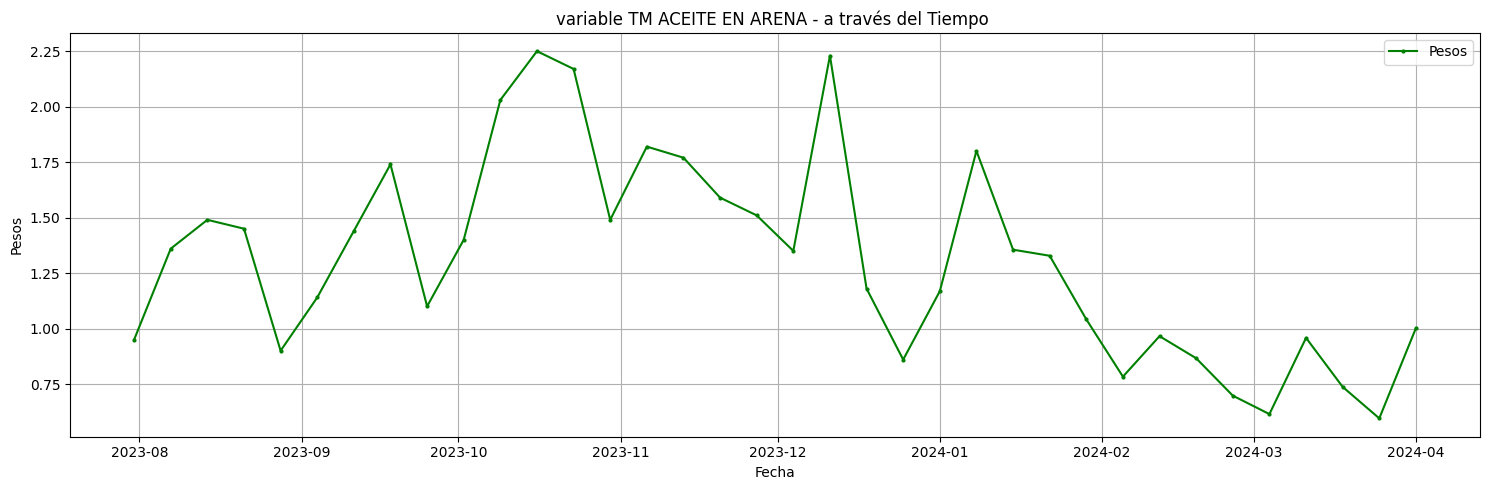

In [198]:
# function_tendencia_unica(df_regresion, 'PRECIPITACION_TOTAL_rolling_2_SHIFTED_24')
# function_tendencia_unica(df_regresion, 'SALDO > 5')
function_tendencia_unica(df_regresion, 'TM ACEITE EN ARENA')

In [199]:
# Eliminamos variables con mucha presencia de missing
# -----
del df_regresion['TM ACEITE SOLIDO TD']
del df_regresion['TM ACEITE EN ARENA']

In [ ]:
df_regresion.tail(30)

In [200]:
# Eliminando valores perdidos del restante de variables
# -----
df_regresion['Peso_ESCOBAJO_propios'] = df_regresion['Peso_ESCOBAJO_propios'].replace(np.nan,0) # Reemplanzando valores escobajo por cero
df_regresion['SALDO > 3'] = df_regresion['SALDO > 3'].replace(np.nan,0) # Reemplanzando valores escobajo por cero
df_regresion['SALDO > 4'] = df_regresion['SALDO > 4'].replace(np.nan,0) # Reemplanzando valores escobajo por cero
df_regresion['SALDO > 5'] = df_regresion['SALDO > 5'].replace(np.nan,0) # Reemplanzando valores escobajo por cero

df_regresion['Peso_VERDES_terceros'] = df_regresion['Peso_VERDES_terceros'].replace(np.nan,0) # Reemplanzando valores escobajo por cero


In [206]:
# Resumen de valores perdidos
# -------
resumen_valores_perdidos_absolutos = df_regresion.groupby('anio').apply(lambda x: x.isnull().sum()).transpose() # absolutos por año
resumen_valores_perdidos_porcentajes = df_regresion.groupby('anio').apply(lambda x: (x.isnull().mean() * 100).round(2)).transpose() # porcentajes por año
# Concatenar los dos resúmenes
resumen_por_año = pd.concat([resumen_valores_perdidos_absolutos, resumen_valores_perdidos_porcentajes], axis=1, keys=['Valores Perdidos Absolutos', 'Porcentaje'])

print("\nResumen de Valores Perdidos por Año:")
resumen_por_año.tail(25)


Resumen de Valores Perdidos por Año:


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_21584\1673673285.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resumen_valores_perdidos_absolutos = df_regresion.groupby('anio').apply(lambda x: x.isnull().sum()).transpose() # absolutos por año
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_21584\1673673285.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resumen_valores_perdidos_porcentajes

Valores Perdidos Absolutos       \
anio                                                           2023 2024   
Peso_VERDES_propios                                               1    0   
Peso_MADUROS_propios                                              1    0   
Peso_SMADUROS_propios                                             1    0   
Peso_ESCOBAJO_propios                                             0    0   
Peso_MALFORMADOA_propios                                          1    0   
Peso_MALFORMADOB_propios                                          1    0   
Peso_VERDES_terceros                                              0    0   
Peso_MADUROS_terceros                                             0    0   
Peso_SMADUROS_terceros                                            0    0   
Peso_ESCOBAJO_terceros                                            0    0   
Peso_MALFORMADO_terceros                                          0    0   
PRECIPITACION_TOTAL_rolling_2_SHIFTED_24                          0    0   
SALDO                                                             0    0   
SALDO > 2                                                         0    0   
SALDO > 3                                                         0    0   
SALDO > 4                                                         0    0   
SALDO > 5                                                         0    0   
TM PERDIDA TOTAL                                                  0    0   
TM ACEITE CONDENSADO                                              0    0   
TM ACEITE ESCOBAJO                                                0    0   
TM ACEITE RACIMO MAL DESFRUTADO                                   0    0   
TM ACEITE FIBRA                                                   0    0   
TM ACEITE AGUA TD                                                 0    0   
TM ACEITE CASCARA                                                 0    0   
anio                                                              0    0   

                                         Porcentaje       
anio                                           2023 2024  
Peso_VERDES_propios                            2.33  0.0  
Peso_MADUROS_propios                           2.33  0.0  
Peso_SMADUROS_propios                          2.33  0.0  
Peso_ESCOBAJO_propios                          0.00  0.0  
Peso_MALFORMADOA_propios                       2.33  0.0  
Peso_MALFORMADOB_propios                       2.33  0.0  
Peso_VERDES_terceros                           0.00  0.0  
Peso_MADUROS_terceros                          0.00  0.0  
Peso_SMADUROS_terceros                         0.00  0.0  
Peso_ESCOBAJO_terceros                         0.00  0.0  
Peso_MALFORMADO_terceros                       0.00  0.0  
PRECIPITACION_TOTAL_rolling_2_SHIFTED_24       0.00  0.0  
SALDO                                          0.00  0.0  
SALDO > 2                                      0.00  0.0  
SALDO > 3                                      0.00  0.0  
SALDO > 4                                      0.00  0.0  
SALDO > 5                                      0.00  0.0  
TM PERDIDA TOTAL                               0.00  0.0  
TM ACEITE CONDENSADO                           0.00  0.0  
TM ACEITE ESCOBAJO                             0.00  0.0  
TM ACEITE RACIMO MAL DESFRUTADO                0.00  0.0  
TM ACEITE FIBRA                                0.00  0.0  
TM ACEITE AGUA TD                              0.00  0.0  
TM ACEITE CASCARA                              0.00  0.0  
anio                                           0.00  0.0

In [205]:
# df_regresion[df_regresion['Peso_VERDES_terceros'].isnull()][['Peso_VERDES_terceros','Peso_MADUROS_terceros', 'Peso_SMADUROS_terceros','Peso_ESCOBAJO_terceros', 'Peso_MALFORMADO_terceros']].head()
# df_regresion[df_regresion['Peso_SMADUROS_propios'].isnull()][['Peso_VERDES_propios', 'Peso_MADUROS_propios', 'Peso_SMADUROS_propios','Peso_ESCOBAJO_propios', 'Peso_MALFORMADOA_propios','Peso_MALFORMADOB_propios']].head()
df_regresion.loc[866]

FECHA                                       2023-03-06 00:00:00
PLANTACION                                              Shanuzi
TEA_total                                              0.248372
RFFProcesado                                             4605.7
RFFProcesadoPropios                                     4215.24
RFFProcesadoTerceros                                     390.46
CPOObtenido                                            1143.925
Peso_VERDES_propios                                         NaN
Peso_MADUROS_propios                                        NaN
Peso_SMADUROS_propios                                       NaN
Peso_ESCOBAJO_propios                                       0.0
Peso_MALFORMADOA_propios                                    NaN
Peso_MALFORMADOB_propios                                    NaN
Peso_VERDES_terceros                                1020.869856
Peso_MADUROS_terceros                             361437.217467
Peso_SMADUROS_terceros                  

In [207]:
# Interpolación lineal
# -----
df_regresion['FECHA'] = pd.to_datetime(df_regresion['FECHA'])
# Establecer la columna FECHA como índice
df_regresion.set_index('FECHA', inplace=True)
df_regresion = df_regresion.interpolate(method='time')


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_21584\4146694751.py:6: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_regresion = df_regresion.interpolate(method='time')


In [208]:
# O, para modificar el DataFrame original directamente:
print('df_regresion_origin: ',df_regresion.shape)
df_regresion.dropna(inplace=True)
print('df_regresion_drop: ',df_regresion.shape)

df_regresion_origin:  (57, 31)
df_regresion_drop:  (56, 31)


In [210]:
# Resumen de valores perdidos
# -------
resumen_valores_perdidos_absolutos = df_regresion.groupby('anio').apply(lambda x: x.isnull().sum()).transpose() # absolutos por año
resumen_valores_perdidos_porcentajes = df_regresion.groupby('anio').apply(lambda x: (x.isnull().mean() * 100).round(2)).transpose() # porcentajes por año
# Concatenar los dos resúmenes
resumen_por_año = pd.concat([resumen_valores_perdidos_absolutos, resumen_valores_perdidos_porcentajes], axis=1, keys=['Valores Perdidos Absolutos', 'Porcentaje'])

print("\nResumen de Valores Perdidos por Año:")
resumen_por_año.tail(20)


Resumen de Valores Perdidos por Año:


C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_21584\530478570.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resumen_valores_perdidos_absolutos = df_regresion.groupby('anio').apply(lambda x: x.isnull().sum()).transpose() # absolutos por año
C:\Users\CESAR QUEZADA\AppData\Local\Temp\ipykernel_21584\530478570.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  resumen_valores_perdidos_porcentajes =

Valores Perdidos Absolutos       \
anio                                                           2023 2024   
Peso_MALFORMADOB_propios                                          0    0   
Peso_VERDES_terceros                                              0    0   
Peso_MADUROS_terceros                                             0    0   
Peso_SMADUROS_terceros                                            0    0   
Peso_ESCOBAJO_terceros                                            0    0   
Peso_MALFORMADO_terceros                                          0    0   
PRECIPITACION_TOTAL_rolling_2_SHIFTED_24                          0    0   
SALDO                                                             0    0   
SALDO > 2                                                         0    0   
SALDO > 3                                                         0    0   
SALDO > 4                                                         0    0   
SALDO > 5                                                         0    0   
TM PERDIDA TOTAL                                                  0    0   
TM ACEITE CONDENSADO                                              0    0   
TM ACEITE ESCOBAJO                                                0    0   
TM ACEITE RACIMO MAL DESFRUTADO                                   0    0   
TM ACEITE FIBRA                                                   0    0   
TM ACEITE AGUA TD                                                 0    0   
TM ACEITE CASCARA                                                 0    0   
anio                                                              0    0   

                                         Porcentaje       
anio                                           2023 2024  
Peso_MALFORMADOB_propios                        0.0  0.0  
Peso_VERDES_terceros                            0.0  0.0  
Peso_MADUROS_terceros                           0.0  0.0  
Peso_SMADUROS_terceros                          0.0  0.0  
Peso_ESCOBAJO_terceros                          0.0  0.0  
Peso_MALFORMADO_terceros                        0.0  0.0  
PRECIPITACION_TOTAL_rolling_2_SHIFTED_24        0.0  0.0  
SALDO                                           0.0  0.0  
SALDO > 2                                       0.0  0.0  
SALDO > 3                                       0.0  0.0  
SALDO > 4                                       0.0  0.0  
SALDO > 5                                       0.0  0.0  
TM PERDIDA TOTAL                                0.0  0.0  
TM ACEITE CONDENSADO                            0.0  0.0  
TM ACEITE ESCOBAJO                              0.0  0.0  
TM ACEITE RACIMO MAL DESFRUTADO                 0.0  0.0  
TM ACEITE FIBRA                                 0.0  0.0  
TM ACEITE AGUA TD                               0.0  0.0  
TM ACEITE CASCARA                               0.0  0.0  
anio                                            0.0  0.0

In [211]:
# Recuperar el índice como una columna en el DataFrame
df_regresion = df_regresion.reset_index()
df_regresion.head()

,FECHA,PLANTACION,TEA_total,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenido,Peso_VERDES_propios,Peso_MADUROS_propios,Peso_SMADUROS_propios,...,SALDO > 4,SALDO > 5,TM PERDIDA TOTAL,TM ACEITE CONDENSADO,TM ACEITE ESCOBAJO,TM ACEITE RACIMO MAL DESFRUTADO,TM ACEITE FIBRA,TM ACEITE AGUA TD,TM ACEITE CASCARA,anio
0,2023-03-13,Shanuzi,0.235963,5813.999,5321.459,492.54,1371.886,151553.916591,4.511324e+06,4.318249e+05,...,267.0,49.0,87.722,1.285,34.567,6.81,36.420,8.30,0.34,2023
1,2023-03-20,Shanuzi,0.236822,3104.499,2744.489,360.01,735.214,25750.693994,2.198585e+06,3.719545e+05,...,467.0,389.0,48.157,0.714,23.664,3.22,17.379,3.03,0.15,2023
2,2023-03-27,Shanuzi,0.231031,5022.049,4639.879,382.17,1160.251,42185.337052,4.033880e+06,8.803414e+05,...,0.0,0.0,77.595,1.732,32.992,5.53,31.131,5.90,0.31,2023
3,2023-04-03,Shanuzi,0.223784,3779.589,3546.189,233.40,845.813,44222.216255,3.922463e+06,7.684204e+05,...,0.0,0.0,60.306,0.698,30.028,4.08,21.180,4.13,0.19,2023
4,2023-04-10,Shanuzi,0.237116,5058.020,4581.000,477.02,1199.336,57128.624632,5.949885e+06,1.123124e+06,...,24.0,0.0,85.797,1.443,39.971,5.05,32.423,6.55,0.36,2023


In [ ]:
# function_tendencia_unica(df_regresion, 'Peso_MADUROS_propios')
function_tendencia_unica(df_regresion, 'Peso_MADUROS_terceros')


#### Creando variables tipo tiempo

In [212]:
df_regresion['mes'] = df_model_match['FECHA'].dt.month
df_regresion['semana'] = df_regresion['FECHA'].dt.isocalendar().week

In [213]:
df_regresion.tail()

,FECHA,PLANTACION,TEA_total,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenido,Peso_VERDES_propios,Peso_MADUROS_propios,Peso_SMADUROS_propios,...,TM PERDIDA TOTAL,TM ACEITE CONDENSADO,TM ACEITE ESCOBAJO,TM ACEITE RACIMO MAL DESFRUTADO,TM ACEITE FIBRA,TM ACEITE AGUA TD,TM ACEITE CASCARA,anio,mes,semana
51,2024-03-04,Shanuzi,0.256107,3293.599,2528.809,764.79,843.514,13258.110032,2.863752e+06,132581.100320,...,72.146075,1.522650,29.983811,2.535396,19.853944,9.674447,1.521593,2024,7,10
52,2024-03-11,Shanuzi,0.260897,5116.788,4122.788,994.00,1334.955,11611.001891,3.902071e+06,158425.670252,...,116.801097,2.872159,54.411155,4.460125,32.951161,9.984512,2.520310,2024,7,11
53,2024-03-18,Shanuzi,0.261365,4415.808,3559.908,855.90,1154.139,12192.876579,3.517264e+06,220614.860608,...,100.020915,1.921958,48.486500,3.645438,28.255535,7.771211,1.980212,2024,8,12
54,2024-03-25,Shanuzi,0.262332,3412.398,2566.158,846.24,895.181,2732.830688,2.003469e+06,118422.663156,...,75.957374,1.158926,35.339597,2.715384,21.568871,6.167116,1.642933,2024,8,13
55,2024-04-01,Shanuzi,0.256533,4497.433,3643.893,853.54,1153.739,4391.833400,3.572903e+06,187384.891738,...,94.943312,1.462364,39.439828,3.518209,30.919292,8.046557,2.082075,2024,8,14


In [139]:
df_regresion.columns

Index(['FECHA', 'PLANTACION', 'TEA_total', 'RFFProcesado',
       'RFFProcesadoPropios', 'RFFProcesadoTerceros', 'CPOObtenido',
       'Peso_VERDES_propios', 'Peso_MADUROS_propios', 'Peso_SMADUROS_propios',
       'Peso_ESCOBAJO_propios', 'Peso_MALFORMADOA_propios',
       'Peso_MALFORMADOB_propios', 'Peso_VERDES_terceros',
       'Peso_MADUROS_terceros', 'Peso_SMADUROS_terceros',
       'Peso_ESCOBAJO_terceros', 'Peso_MALFORMADO_terceros',
       'PRECIPITACION_TOTAL_rolling_2_SHIFTED_24', 'SALDO', 'SALDO > 2',
       'SALDO > 3', 'SALDO > 4', 'SALDO > 5', 'anio', 'mes', 'semana'],
      dtype='object')

### 3. Ingeniera de caractestisticas

In [216]:
df_model = df_regresion
print(df_model.columns)
df_model.head()

Index(['FECHA', 'PLANTACION', 'TEA_total', 'RFFProcesado',
       'RFFProcesadoPropios', 'RFFProcesadoTerceros', 'CPOObtenido',
       'Peso_VERDES_propios', 'Peso_MADUROS_propios', 'Peso_SMADUROS_propios',
       'Peso_ESCOBAJO_propios', 'Peso_MALFORMADOA_propios',
       'Peso_MALFORMADOB_propios', 'Peso_VERDES_terceros',
       'Peso_MADUROS_terceros', 'Peso_SMADUROS_terceros',
       'Peso_ESCOBAJO_terceros', 'Peso_MALFORMADO_terceros',
       'PRECIPITACION_TOTAL_rolling_2_SHIFTED_24', 'SALDO', 'SALDO > 2',
       'SALDO > 3', 'SALDO > 4', 'SALDO > 5', 'TM PERDIDA TOTAL',
       'TM ACEITE CONDENSADO', 'TM ACEITE ESCOBAJO',
       'TM ACEITE RACIMO MAL DESFRUTADO', 'TM ACEITE FIBRA',
       'TM ACEITE AGUA TD', 'TM ACEITE CASCARA', 'anio', 'mes', 'semana'],
      dtype='object')


,FECHA,PLANTACION,TEA_total,RFFProcesado,RFFProcesadoPropios,RFFProcesadoTerceros,CPOObtenido,Peso_VERDES_propios,Peso_MADUROS_propios,Peso_SMADUROS_propios,...,TM PERDIDA TOTAL,TM ACEITE CONDENSADO,TM ACEITE ESCOBAJO,TM ACEITE RACIMO MAL DESFRUTADO,TM ACEITE FIBRA,TM ACEITE AGUA TD,TM ACEITE CASCARA,anio,mes,semana
0,2023-03-13,Shanuzi,0.235963,5813.999,5321.459,492.54,1371.886,151553.916591,4.511324e+06,4.318249e+05,...,87.722,1.285,34.567,6.81,36.420,8.30,0.34,2023,7,11
1,2023-03-20,Shanuzi,0.236822,3104.499,2744.489,360.01,735.214,25750.693994,2.198585e+06,3.719545e+05,...,48.157,0.714,23.664,3.22,17.379,3.03,0.15,2023,8,12
2,2023-03-27,Shanuzi,0.231031,5022.049,4639.879,382.17,1160.251,42185.337052,4.033880e+06,8.803414e+05,...,77.595,1.732,32.992,5.53,31.131,5.90,0.31,2023,8,13
3,2023-04-03,Shanuzi,0.223784,3779.589,3546.189,233.40,845.813,44222.216255,3.922463e+06,7.684204e+05,...,60.306,0.698,30.028,4.08,21.180,4.13,0.19,2023,8,14
4,2023-04-10,Shanuzi,0.237116,5058.020,4581.000,477.02,1199.336,57128.624632,5.949885e+06,1.123124e+06,...,85.797,1.443,39.971,5.05,32.423,6.55,0.36,2023,8,15


In [217]:
df_model = df_model.drop(['FECHA'],axis = 1)
df_model = df_model.drop(['PLANTACION'],axis = 1)
df_model = df_model.drop(['RFFProcesado'],axis = 1)
df_model = df_model.drop(['RFFProcesadoPropios'],axis = 1)
df_model = df_model.drop(['RFFProcesadoTerceros'],axis = 1)
df_model = df_model.drop(['TEA_total'],axis = 1)
df_model = df_model.drop(['SALDO'],axis = 1)
# df_model = df_model.drop(['CPOObtenido'],axis = 1)
df_model = df_model.drop(['SALDO > 4'],axis = 1)
df_model = df_model.drop(['SALDO > 5'],axis = 1)
# df_model = df_model.drop(['anio'],axis = 1)

print(df_model.columns)
df_model.head()

Index(['CPOObtenido', 'Peso_VERDES_propios', 'Peso_MADUROS_propios',
       'Peso_SMADUROS_propios', 'Peso_ESCOBAJO_propios',
       'Peso_MALFORMADOA_propios', 'Peso_MALFORMADOB_propios',
       'Peso_VERDES_terceros', 'Peso_MADUROS_terceros',
       'Peso_SMADUROS_terceros', 'Peso_ESCOBAJO_terceros',
       'Peso_MALFORMADO_terceros', 'PRECIPITACION_TOTAL_rolling_2_SHIFTED_24',
       'SALDO > 2', 'SALDO > 3', 'TM PERDIDA TOTAL', 'TM ACEITE CONDENSADO',
       'TM ACEITE ESCOBAJO', 'TM ACEITE RACIMO MAL DESFRUTADO',
       'TM ACEITE FIBRA', 'TM ACEITE AGUA TD', 'TM ACEITE CASCARA', 'anio',
       'mes', 'semana'],
      dtype='object')


,CPOObtenido,Peso_VERDES_propios,Peso_MADUROS_propios,Peso_SMADUROS_propios,Peso_ESCOBAJO_propios,Peso_MALFORMADOA_propios,Peso_MALFORMADOB_propios,Peso_VERDES_terceros,Peso_MADUROS_terceros,Peso_SMADUROS_terceros,...,TM PERDIDA TOTAL,TM ACEITE CONDENSADO,TM ACEITE ESCOBAJO,TM ACEITE RACIMO MAL DESFRUTADO,TM ACEITE FIBRA,TM ACEITE AGUA TD,TM ACEITE CASCARA,anio,mes,semana
0,1371.886,151553.916591,4.511324e+06,4.318249e+05,0.000000,6228.243148,29065.134689,373.520479,441269.396918,12296.750922,...,87.722,1.285,34.567,6.81,36.420,8.30,0.34,2023,7,11
1,735.214,25750.693994,2.198585e+06,3.719545e+05,0.000000,18359.291089,14544.373460,404.280000,301490.150130,13026.828356,...,48.157,0.714,23.664,3.22,17.379,3.03,0.15,2023,8,12
2,1160.251,42185.337052,4.033880e+06,8.803414e+05,0.000000,206486.123466,84370.674104,249.005842,327343.895629,20337.855973,...,77.595,1.732,32.992,5.53,31.131,5.90,0.31,2023,8,13
3,845.813,44222.216255,3.922463e+06,7.684204e+05,0.000000,209698.896434,134568.679571,756.716097,215253.147073,14313.981136,...,60.306,0.698,30.028,4.08,21.180,4.13,0.19,2023,8,14
4,1199.336,57128.624632,5.949885e+06,1.123124e+06,80628.342565,362624.957768,347633.758397,389.463613,356878.767505,19685.778185,...,85.797,1.443,39.971,5.05,32.423,6.55,0.36,2023,8,15


Analisis de correlación

In [218]:
# Antes de poder realizar el modelo de regresión lineal debemos ver si existe asociación y de qué tipo es.
# coeficiente de correlación
df_model.corr()

,CPOObtenido,Peso_VERDES_propios,Peso_MADUROS_propios,Peso_SMADUROS_propios,Peso_ESCOBAJO_propios,Peso_MALFORMADOA_propios,Peso_MALFORMADOB_propios,Peso_VERDES_terceros,Peso_MADUROS_terceros,Peso_SMADUROS_terceros,...,TM PERDIDA TOTAL,TM ACEITE CONDENSADO,TM ACEITE ESCOBAJO,TM ACEITE RACIMO MAL DESFRUTADO,TM ACEITE FIBRA,TM ACEITE AGUA TD,TM ACEITE CASCARA,anio,mes,semana
CPOObtenido,1.000000,-0.139633,0.944375,0.103521,0.428938,0.536335,0.106758,-0.191930,0.649007,-0.320333,...,0.943456,0.726437,0.920291,0.460187,0.975012,0.889787,0.010525,-0.179707,-0.663599,0.577493
Peso_VERDES_propios,-0.139633,1.000000,-0.047843,0.313175,0.052359,-0.003178,0.334684,-0.270884,-0.368307,-0.141580,...,-0.299070,-0.299148,-0.321712,0.412042,-0.102907,-0.247627,-0.421067,-0.413871,0.261143,-0.071059
Peso_MADUROS_propios,0.944375,-0.047843,1.000000,0.197436,0.479853,0.696295,0.300278,-0.264725,0.558756,-0.392484,...,0.853277,0.627624,0.840909,0.537230,0.929763,0.806150,-0.162691,-0.338960,-0.648856,0.635793
Peso_SMADUROS_propios,0.103521,0.313175,0.197436,1.000000,0.468225,0.261144,0.352726,-0.324047,-0.319326,-0.196884,...,0.014983,-0.009547,0.002130,0.388337,0.162210,-0.051364,-0.252610,-0.325062,0.089762,-0.070194
Peso_ESCOBAJO_propios,0.428938,0.052359,0.479853,0.468225,1.000000,0.588805,0.626243,-0.373555,-0.020482,-0.345407,...,0.317212,0.259064,0.292985,0.236872,0.394581,0.363908,-0.141695,-0.280261,-0.060308,0.215598
Peso_MALFORMADOA_propios,0.536335,-0.003178,0.696295,0.261144,0.588805,1.000000,0.735362,-0.354388,0.142663,-0.392393,...,0.430488,0.295019,0.432668,0.336592,0.526299,0.438011,-0.281072,-0.409496,-0.438539,0.435485
Peso_MALFORMADOB_propios,0.106758,0.334684,0.300278,0.352726,0.626243,0.735362,1.000000,-0.446581,-0.295371,-0.310915,...,-0.071161,-0.103107,-0.066080,0.248761,0.105007,0.032802,-0.534426,-0.588612,0.129598,0.261012
Peso_VERDES_terceros,-0.191930,-0.270884,-0.264725,-0.324047,-0.373555,-0.354388,-0.446581,1.000000,0.199533,0.361717,...,-0.051274,-0.049344,-0.071888,-0.161850,-0.195842,-0.098601,0.480945,0.616414,0.016195,-0.333617
Peso_MADUROS_terceros,0.649007,-0.368307,0.558756,-0.319326,-0.020482,0.142663,-0.295371,0.199533,1.000000,0.122232,...,0.707142,0.545784,0.699104,0.138300,0.614554,0.607531,0.300271,0.243396,-0.608161,0.316384
Peso_SMADUROS_terceros,-0.320333,-0.141580,-0.392484,-0.196884,-0.345407,-0.392393,-0.310915,0.361717,0.122232,1.000000,...,-0.201805,-0.105771,-0.230486,-0.266398,-0.337082,-0.239124,0.529764,0.612362,0.246543,-0.563577


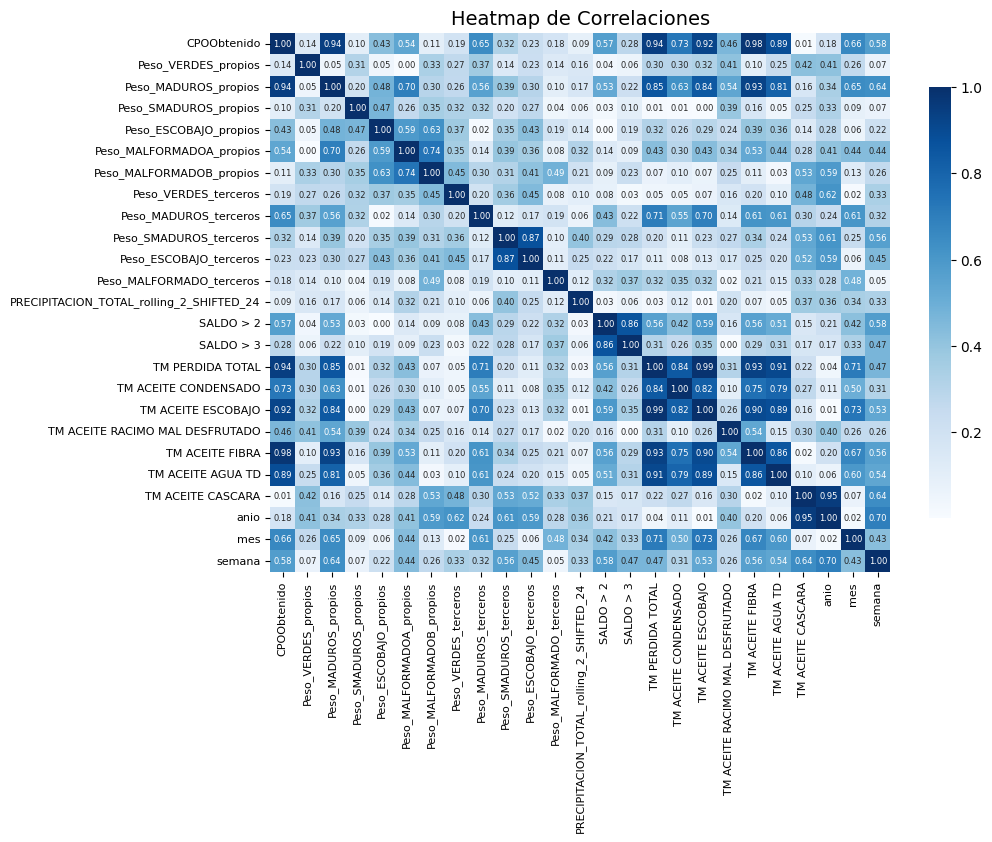

In [267]:
# Gráfico de calor de correlaciones
plt.figure(figsize=(10, 7))

# Crear el heatmap con ajustes
sns.heatmap(
    abs(df_model.corr()),      # Correlación en valores absolutos
    annot=True,                # Mostrar los valores de correlación
    fmt='.2f',                 # Formato de los números en las celdas (1 decimal)
    cmap='Blues',              # Color del heatmap
    annot_kws={"size": 6},     # Tamaño del texto de las anotaciones
    cbar_kws={'shrink': .8}    # Ajusta el tamaño de la barra de color
)

# Ajustar las etiquetas de las variables (ejes)
# plt.xticks(rotation=45, ha='right', fontsize=8)  # Rotar las etiquetas del eje x y ajustar su tamaño
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)                           # Ajustar el tamaño de las etiquetas del eje y

plt.title('Heatmap de Correlaciones', fontsize=14)  # Añadir título y ajustar su tamaño
plt.show()

In [148]:
# Retirando correlaciones altas
# -----
corr_matrix = df_model.corr()
corr_pairs = corr_matrix.unstack() # Reestructura la matriz de correlación
corr_pairs = corr_pairs[corr_pairs.index.get_level_values(0) != corr_pairs.index.get_level_values(1)] # Filtra las correlaciones duplicadas y las correlaciones consigo mismas (diagonal)
sorted_corr_pairs = corr_pairs.sort_values(ascending=False).drop_duplicates() # Ordena las correlaciones de mayor a menor
result_df_corr = pd.DataFrame(sorted_corr_pairs, columns=['Correlation']) # Convierte la serie resultante a un DataFrame
result_df_corr.reset_index(inplace=True)
result_df_corr.columns = ['Var1', 'Var2', 'Correlation']
result_df_corr.head(15)

,Var1,Var2,Correlation
0,Peso_MADUROS_propios,CPOObtenido,0.944375
1,Peso_SMADUROS_terceros,Peso_ESCOBAJO_terceros,0.874953
2,SALDO > 2,SALDO > 3,0.861461
3,Peso_MALFORMADOB_propios,Peso_MALFORMADOA_propios,0.735362
4,Peso_MALFORMADOA_propios,Peso_MADUROS_propios,0.696295
5,Peso_MADUROS_terceros,CPOObtenido,0.649007
6,semana,Peso_MADUROS_propios,0.635793
7,Peso_ESCOBAJO_propios,Peso_MALFORMADOB_propios,0.626243
8,anio,Peso_VERDES_terceros,0.616414
9,Peso_SMADUROS_terceros,anio,0.612362


In [149]:
price_df_corr = result_df_corr[(result_df_corr['Var1'] == 'CPOObtenido') | (result_df_corr['Var2'] == 'CPOObtenido')]
price_df_corr

,Var1,Var2,Correlation
0,Peso_MADUROS_propios,CPOObtenido,0.944375
5,Peso_MADUROS_terceros,CPOObtenido,0.649007
12,semana,CPOObtenido,0.577493
14,SALDO > 2,CPOObtenido,0.570021
16,Peso_MALFORMADOA_propios,CPOObtenido,0.536335
26,Peso_ESCOBAJO_propios,CPOObtenido,0.428938
35,SALDO > 3,CPOObtenido,0.279991
57,Peso_MALFORMADOB_propios,CPOObtenido,0.106758
58,Peso_SMADUROS_propios,CPOObtenido,0.103521
60,CPOObtenido,PRECIPITACION_TOTAL_rolling_2_SHIFTED_24,0.090563


In [150]:
var_df_corr = result_df_corr[~(((result_df_corr['Var1'] == 'CPOObtenido') | (result_df_corr['Var2'] == 'CPOObtenido')) & (result_df_corr['Correlation'].abs() >= 0.6))]
var_df_corr.head(15)

,Var1,Var2,Correlation
1,Peso_SMADUROS_terceros,Peso_ESCOBAJO_terceros,0.874953
2,SALDO > 2,SALDO > 3,0.861461
3,Peso_MALFORMADOB_propios,Peso_MALFORMADOA_propios,0.735362
4,Peso_MALFORMADOA_propios,Peso_MADUROS_propios,0.696295
6,semana,Peso_MADUROS_propios,0.635793
7,Peso_ESCOBAJO_propios,Peso_MALFORMADOB_propios,0.626243
8,anio,Peso_VERDES_terceros,0.616414
9,Peso_SMADUROS_terceros,anio,0.612362
10,anio,Peso_ESCOBAJO_terceros,0.591292
11,Peso_MALFORMADOA_propios,Peso_ESCOBAJO_propios,0.588805


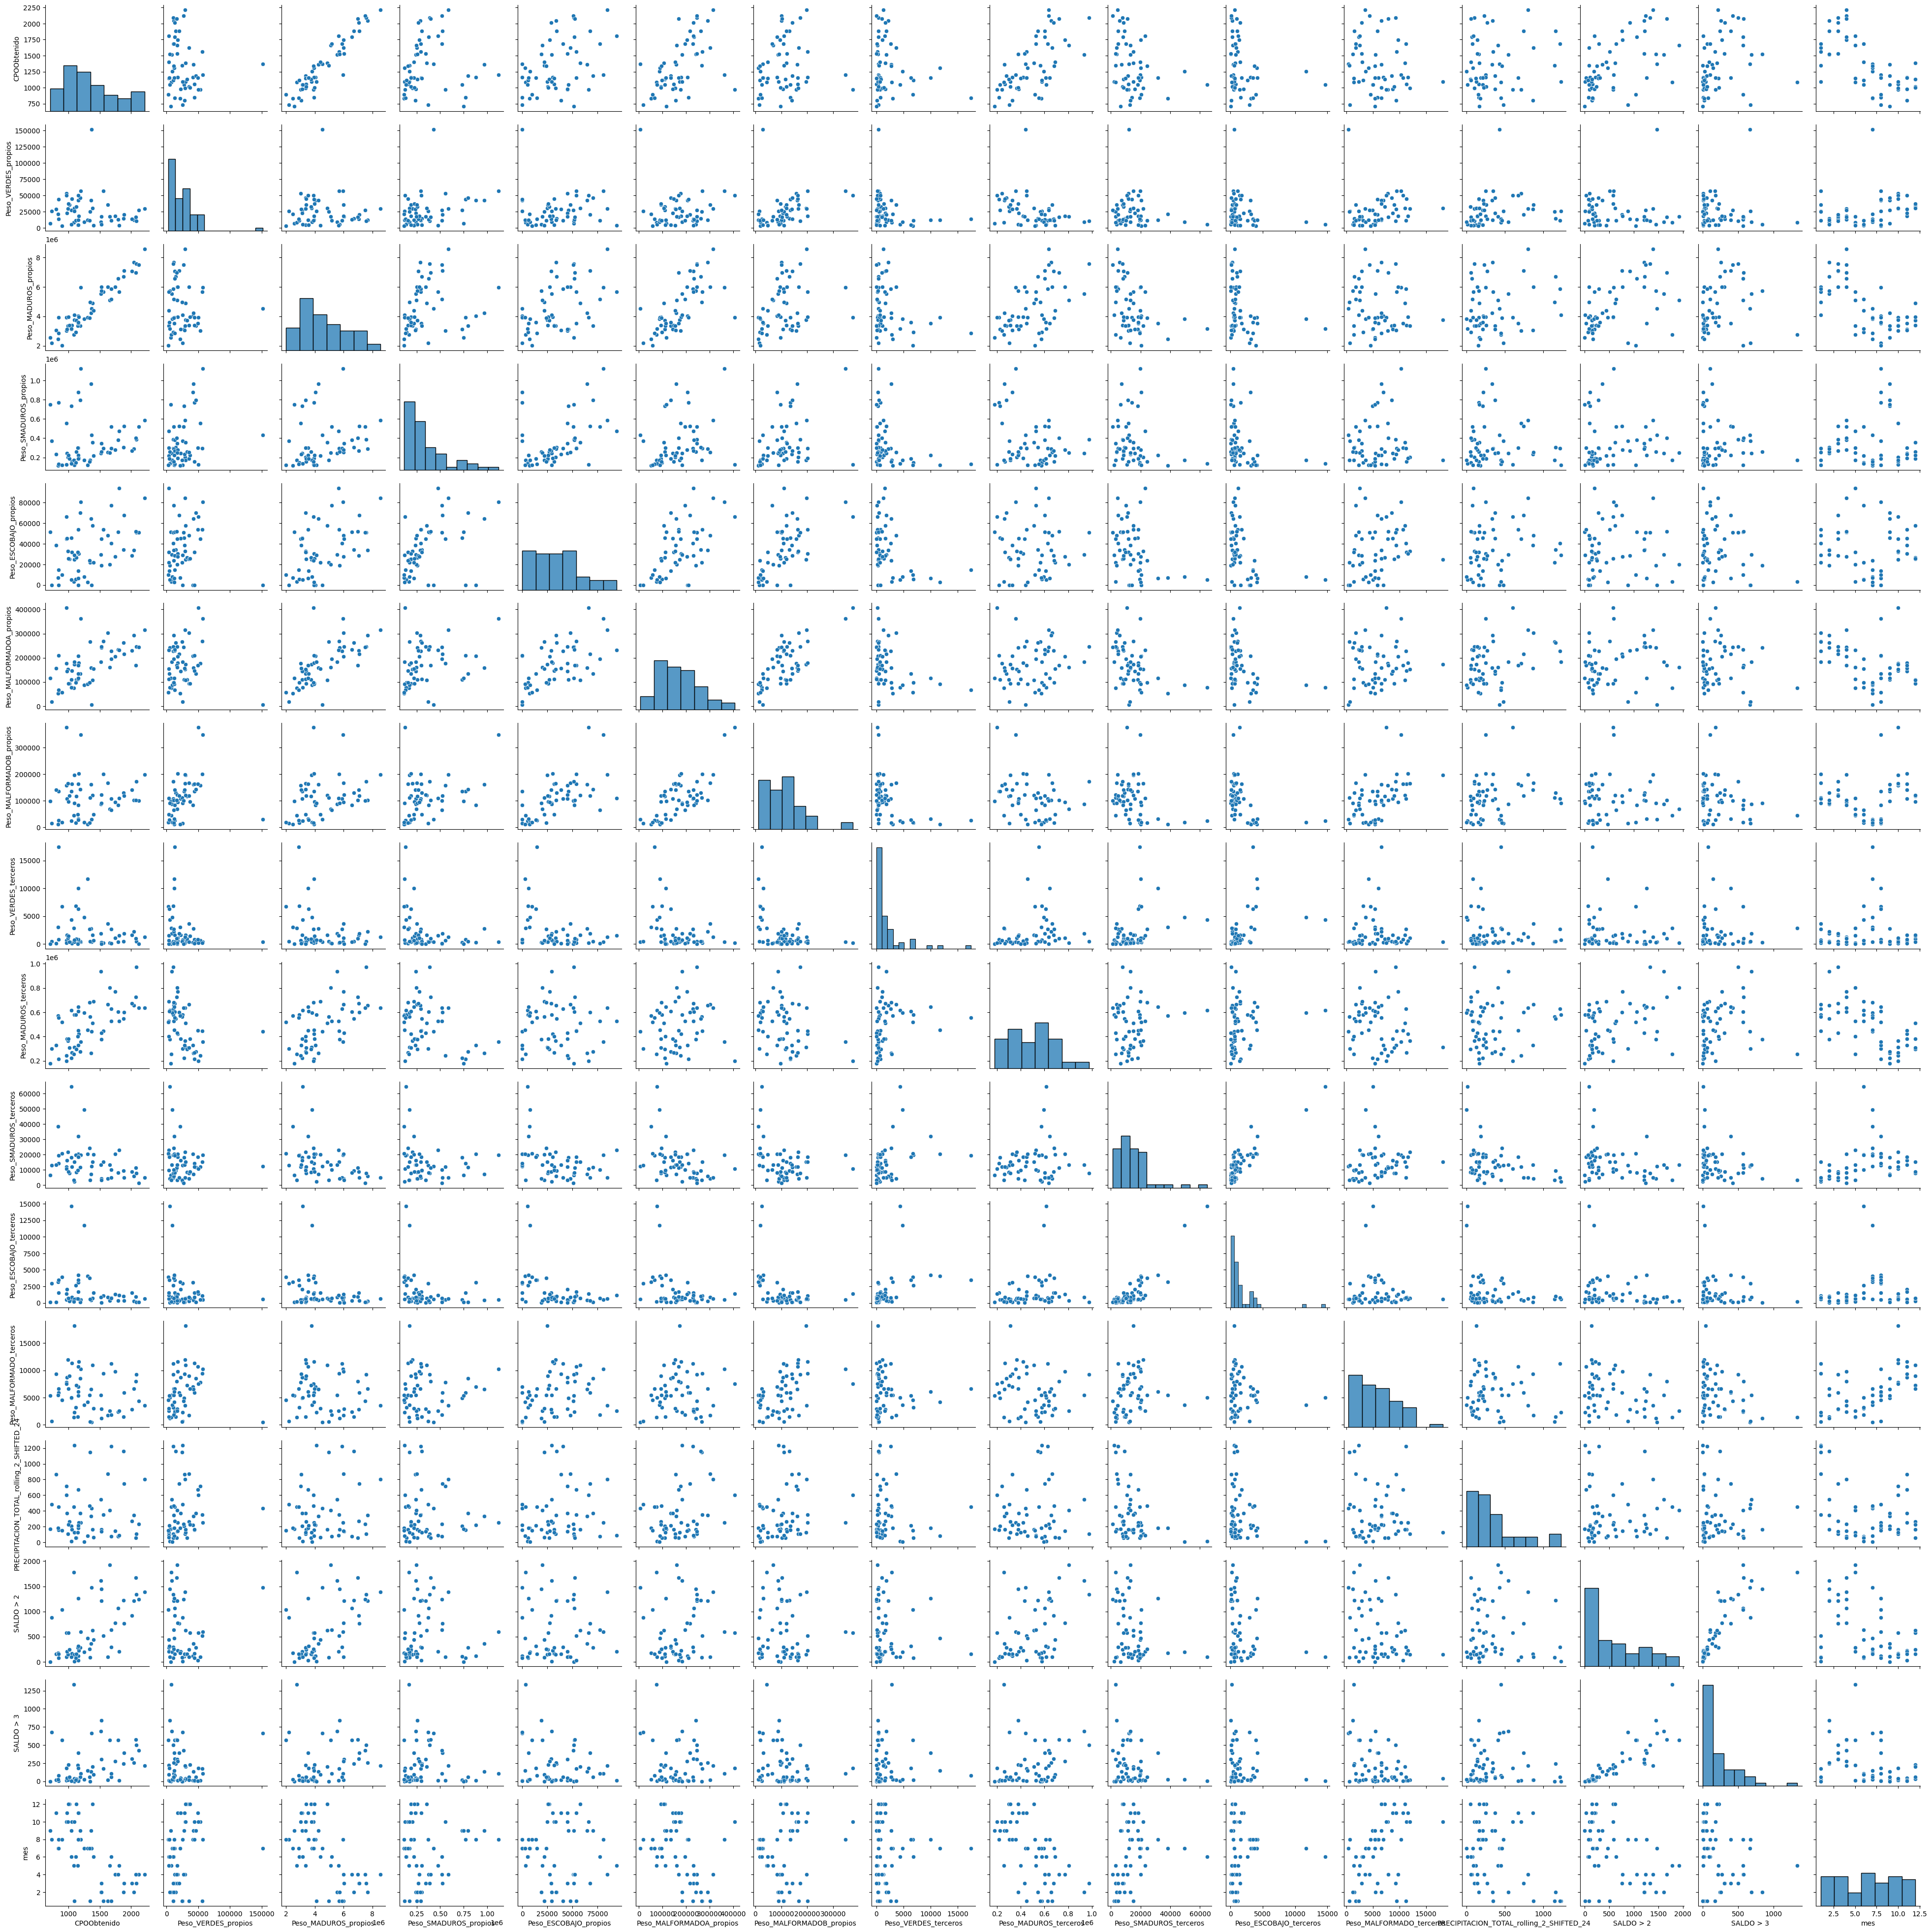

In [81]:
# Gráfico de dispersión multiple
par= sns.pairplot(df_model)

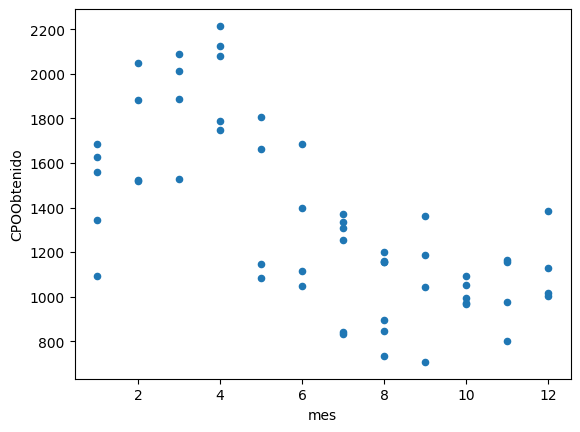

In [82]:
# diagrama de dispersión
# disp= df_model.plot(kind='scatter', x='Peso_MADUROS_propios', y='CPOObtenido')
# disp= df_model.plot(kind='scatter', x='Peso_MADUROS_propios', y='TEA_total')
# disp= df_model.plot(kind='scatter', x='SALDO > 2', y='CPOObtenido')
disp= df_model.plot(kind='scatter', x='mes', y='CPOObtenido')


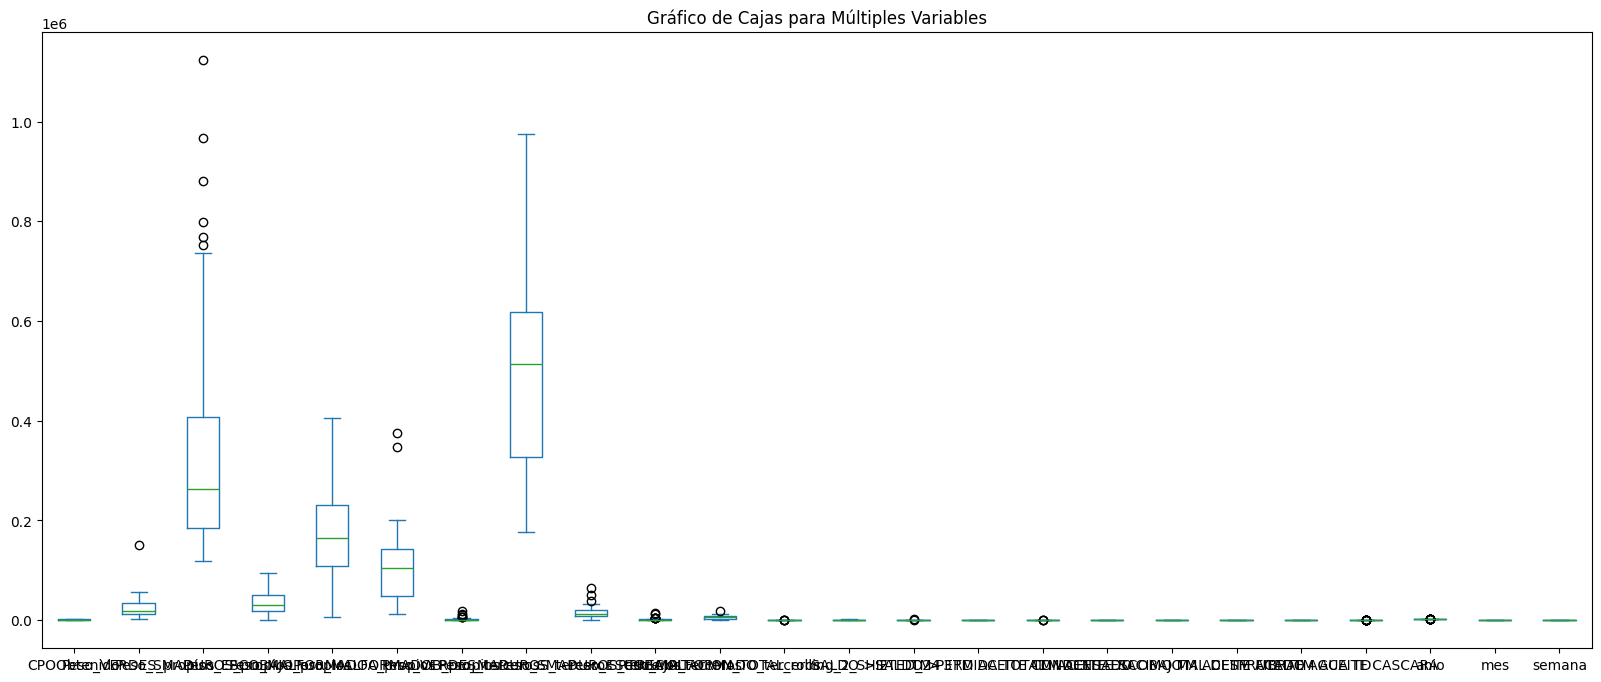

In [220]:
# Crear un gráfico de cajas para todas las variables
# df_model.plot(kind='box', figsize=(20, 8))
df_model.loc[:, df_model.columns != 'Peso_MADUROS_propios'].plot(kind='box', figsize=(20, 8))

# Mostrar el gráfico
plt.title('Gráfico de Cajas para Múltiples Variables')
plt.show()

In [221]:
for k, v in df_model.items():
  q1 = v.quantile(0.25)
  q3 = v.quantile(0.75)
  irq = q3 - q1
  v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
  perc = np.shape(v_col)[0] * 100.0 / np.shape(df_model)[0]
  print("Column %s outliers = %.2f%%" % (k, perc))

Column CPOObtenido outliers = 0.00%
Column Peso_VERDES_propios outliers = 1.79%
Column Peso_MADUROS_propios outliers = 0.00%
Column Peso_SMADUROS_propios outliers = 10.71%
Column Peso_ESCOBAJO_propios outliers = 0.00%
Column Peso_MALFORMADOA_propios outliers = 0.00%
Column Peso_MALFORMADOB_propios outliers = 3.57%
Column Peso_VERDES_terceros outliers = 10.71%
Column Peso_MADUROS_terceros outliers = 0.00%
Column Peso_SMADUROS_terceros outliers = 5.36%
Column Peso_ESCOBAJO_terceros outliers = 14.29%
Column Peso_MALFORMADO_terceros outliers = 1.79%
Column PRECIPITACION_TOTAL_rolling_2_SHIFTED_24 outliers = 7.14%
Column SALDO > 2 outliers = 0.00%
Column SALDO > 3 outliers = 3.57%
Column TM PERDIDA TOTAL outliers = 0.00%
Column TM ACEITE CONDENSADO outliers = 5.36%
Column TM ACEITE ESCOBAJO outliers = 0.00%
Column TM ACEITE RACIMO MAL DESFRUTADO outliers = 0.00%
Column TM ACEITE FIBRA outliers = 0.00%
Column TM ACEITE AGUA TD outliers = 0.00%
Column TM ACEITE CASCARA outliers = 23.21%
Colum

Analisis de  2023-03-13 00:00:00  hasta  2024-04-01 00:00:00


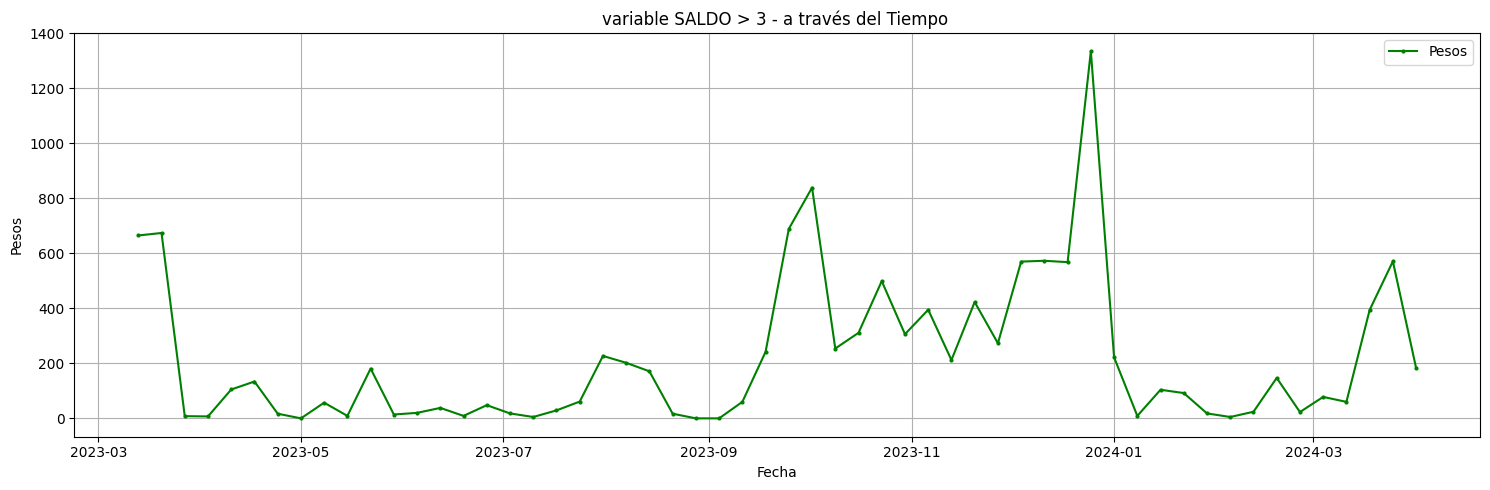

In [94]:
function_tendencia_unica(df_regresion, 'SALDO > 3')

In [88]:
df_model.head()

,CPOObtenido,Peso_VERDES_propios,Peso_MADUROS_propios,Peso_SMADUROS_propios,Peso_ESCOBAJO_propios,Peso_MALFORMADOA_propios,Peso_MALFORMADOB_propios,Peso_VERDES_terceros,Peso_MADUROS_terceros,Peso_SMADUROS_terceros,Peso_ESCOBAJO_terceros,Peso_MALFORMADO_terceros,PRECIPITACION_TOTAL_rolling_2_SHIFTED_24,SALDO > 2,SALDO > 3,mes
0,1371.886,151553.916591,4.511324e+06,4.318249e+05,0.000000,6228.243148,29065.134689,373.520479,441269.396918,12296.750922,550.331681,425.840349,431.105,1475.0,665.0,7
1,735.214,25750.693994,2.198585e+06,3.719545e+05,0.000000,18359.291089,14544.373460,404.280000,301490.150130,13026.828356,2958.741514,676.544681,484.110,879.0,674.0,8
2,1160.251,42185.337052,4.033880e+06,8.803414e+05,0.000000,206486.123466,84370.674104,249.005842,327343.895629,20337.855973,3119.242557,6982.995336,221.000,112.0,8.0,8
3,845.813,44222.216255,3.922463e+06,7.684204e+05,0.000000,209698.896434,134568.679571,756.716097,215253.147073,14313.981136,1566.155694,5895.759047,160.750,78.0,7.0,8
4,1199.336,57128.624632,5.949885e+06,1.123124e+06,80628.342565,362624.957768,347633.758397,389.463613,356878.767505,19685.778185,465.990698,10283.078863,253.550,592.0,105.0,8


<Axes: >

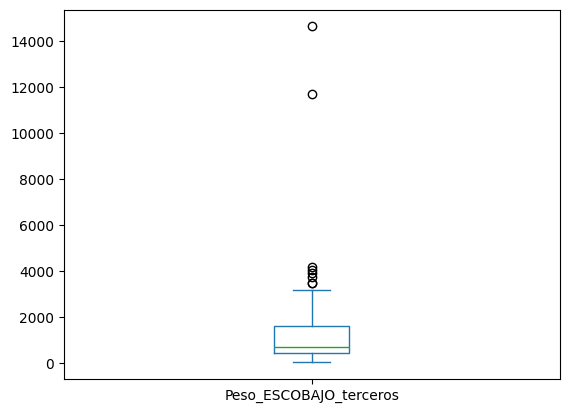

In [86]:
df_model['Peso_ESCOBAJO_terceros'].plot(kind='box')

In [ ]:
df_model = imputar_valores_extremos(df_model, 'Peso_ESCOBAJO_terceros')

In [ ]:
df_model = imputar_valores_extremos(df_model, 'Peso_SMADUROS_propios')

### 4. Probando modelos

In [222]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [223]:
df_model.columns

Index(['CPOObtenido', 'Peso_VERDES_propios', 'Peso_MADUROS_propios',
       'Peso_SMADUROS_propios', 'Peso_ESCOBAJO_propios',
       'Peso_MALFORMADOA_propios', 'Peso_MALFORMADOB_propios',
       'Peso_VERDES_terceros', 'Peso_MADUROS_terceros',
       'Peso_SMADUROS_terceros', 'Peso_ESCOBAJO_terceros',
       'Peso_MALFORMADO_terceros', 'PRECIPITACION_TOTAL_rolling_2_SHIFTED_24',
       'SALDO > 2', 'SALDO > 3', 'TM PERDIDA TOTAL', 'TM ACEITE CONDENSADO',
       'TM ACEITE ESCOBAJO', 'TM ACEITE RACIMO MAL DESFRUTADO',
       'TM ACEITE FIBRA', 'TM ACEITE AGUA TD', 'TM ACEITE CASCARA', 'anio',
       'mes', 'semana'],
      dtype='object')

In [224]:
# Al dataset o set de entrenamiento le retiramos la variable dependiente o target
# X = df_model.drop("TEA_total",axis=1) # covariables
# Y = df_model['TEA_total'] # target

X = df_model.drop("CPOObtenido",axis=1) # covariables
Y = df_model['CPOObtenido'] # target

##### 4.1. Regresion lineal multiple

In [225]:
# Creamos nuestro set de datos
random.seed(123)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=20)

# Creamos nuestro modelo general de regresión lineal múltiple
lrm = LinearRegression()
# Ajustamos nuestro modelo a nuestra base train
lrm_model = lrm.fit(X_train, Y_train)

# Mostramos los coeficientes del modelo
intercepto_m = lrm_model.intercept_
coeficiente_m = lrm_model.coef_

print("El núnero de coeficientes es :")
print(len(lrm_model.coef_))

# Podemos observar todos los coeficientes asignados con sus nombres
coef=pd.DataFrame(lrm_model.coef_,X.columns)
coef

El núnero de coeficientes es :
24


,0
Peso_VERDES_propios,0.000149
Peso_MADUROS_propios,0.000098
Peso_SMADUROS_propios,-0.000078
Peso_ESCOBAJO_propios,0.000941
Peso_MALFORMADOA_propios,-0.000452
Peso_MALFORMADOB_propios,0.000104
Peso_VERDES_terceros,-0.003502
Peso_MADUROS_terceros,0.000099
Peso_SMADUROS_terceros,-0.001253
Peso_ESCOBAJO_terceros,0.007857


In [226]:
# Obtenemos las predicciones
X_pred_m = lrm_model.predict(X_train)
Y_pred_m = lrm_model.predict(X_test)

In [227]:
# Obtenemos las funciones de coste
print ('Error cuadrático medio:')
print('Train:',mean_squared_error(Y_train, X_pred_m))
print('Test:',mean_squared_error(Y_test, Y_pred_m))

print ('Raiz Error cuadrático medio:')
print('Train:',np.sqrt(mean_squared_error(Y_train, X_pred_m)))
print('Test:',np.sqrt(mean_squared_error(Y_test, Y_pred_m)))

print ('R cuadrado:')
print('Train:',r2_score(Y_train, X_pred_m))
print('Test:',r2_score(Y_test, Y_pred_m))

Error cuadrático medio:
Train: 2025.6674392667408
Test: 3900.8273571879
Raiz Error cuadrático medio:
Train: 45.0074153808763
Test: 62.45660379165601
R cuadrado:
Train: 0.9885160418886897
Test: 0.9594443859764107


##### 4.2. Regresión Penalizada : Ridge

In [228]:
from sklearn.preprocessing import scale  
from sklearn.model_selection import train_test_split # Partición muestral
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_squared_error

In [229]:
# Creamos un vector con los valores de alpha o constante de penalización
alphas = 10**np.linspace(10,-1,100)*0.5
print(alphas.shape)
print(alphas[:10])

(100,)
[5.00000000e+09 3.87131841e+09 2.99742125e+09 2.32079442e+09
 1.79690683e+09 1.39127970e+09 1.07721735e+09 8.34050269e+08
 6.45774833e+08 5.00000000e+08]


In [230]:
# Al dataset o set de entrenamiento le retiramos la variable dependiente o target
# X = df_model.drop("TEA_total",axis=1) # covariables
# Y = df_model['TEA_total'] # target

X = df_model.drop("CPOObtenido",axis=1) # covariables
Y = df_model['CPOObtenido'] # target


In [231]:
from sklearn.preprocessing import StandardScaler

# Normaliza los datos manualmente
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

(100, 24)


Text(0, 0.5, 'weights')

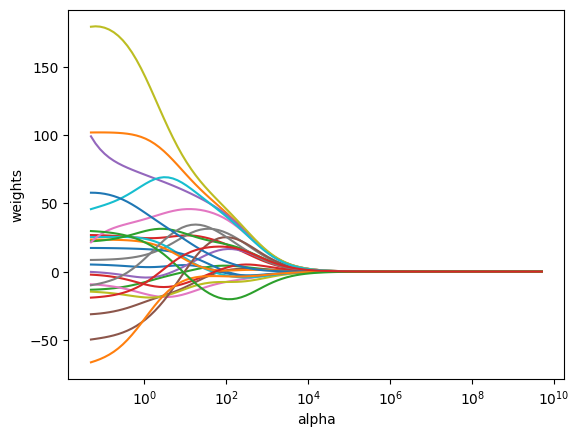

In [232]:
# Generamos el ajuste de las regresiones para cada valor de alpha
ridge = Ridge()
coefs = []
# Itera sobre los valores de alpha
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(X_scaled, Y)
    coefs.append(ridge.coef_)
    
print(np.shape(coefs))

# Graficamos los valores de alpha
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [233]:
# Normaliza los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Le asignamos un valor pequeño a alpha y observamos que pasa con el error en el test
ridge = Ridge(alpha = 0.001)
ridge.fit(X_train_scaled, Y_train)            # Ajustamos el modelo ridge

# print(pd.Series(ridge.coef_, index = X.columns).sort_values(ascending=False)) # Pintamos los coeficientes
print(pd.Series(ridge.coef_, index = X.columns)) # Pintamos los coeficientes

Peso_VERDES_propios                           4.740121
Peso_MADUROS_propios                        161.037699
Peso_SMADUROS_propios                       -13.520347
Peso_ESCOBAJO_propios                        22.543281
Peso_MALFORMADOA_propios                    -37.124396
Peso_MALFORMADOB_propios                      6.207938
Peso_VERDES_terceros                        -10.420406
Peso_MADUROS_terceros                        19.723150
Peso_SMADUROS_terceros                      -15.920708
Peso_ESCOBAJO_terceros                       19.789750
Peso_MALFORMADO_terceros                     11.178144
PRECIPITACION_TOTAL_rolling_2_SHIFTED_24     18.208288
SALDO > 2                                    27.317567
SALDO > 3                                   -10.595126
TM PERDIDA TOTAL                            461.057032
TM ACEITE CONDENSADO                        -52.573121
TM ACEITE ESCOBAJO                         -200.329565
TM ACEITE RACIMO MAL DESFRUTADO             -18.768956
TM ACEITE 

In [234]:
# Obtenemos las predicciones
X_pred_rg = ridge.predict(X_train_scaled)
Y_pred_rg = ridge.predict(X_test_scaled)

In [235]:
# Obtenemos las funciones de coste
print ('Error cuadrático medio:')
print('Train:',mean_squared_error(Y_train, X_pred_rg))
print('Test:',mean_squared_error(Y_test, Y_pred_rg),'\n')

print ('Raiz Error cuadrático medio:')
print('Train:',np.sqrt(mean_squared_error(Y_train, X_pred_rg)))
print('Test:',np.sqrt(mean_squared_error(Y_test, Y_pred_rg)),'\n')

print ('R cuadrado:')
print('Train:',r2_score(Y_train, X_pred_rg))
print('Test:',r2_score(Y_test, Y_pred_rg))

Error cuadrático medio:
Train: 2029.6720883249695
Test: 3762.173020870184 

Raiz Error cuadrático medio:
Train: 45.05188218404387
Test: 61.33655533913022 

R cuadrado:
Train: 0.9884933386447396
Test: 0.9608859293290117


In [236]:
# Podemos hallar el mejor valor de alpha por Cv
# ---------------------------------------------
ridgecv = RidgeCV(alphas = alphas, scoring = 'neg_mean_squared_error')
ridgecv.fit(X_train_scaled, Y_train)
print('best_alpha: ',ridgecv.alpha_)

# Probamos la regresión Rige con el mejor alpha
ridge3 = Ridge(alpha = ridgecv.alpha_)
ridge3.fit(X_train_scaled, Y_train)             # Ajuste del modelo ridge

best_alpha:  1.796906831902313


Ridge(alpha=1.796906831902313)

In [237]:
# Obtenemos las predicciones
X_pred_rg3 = ridge3.predict(X_train_scaled)
Y_pred_rg3 = ridge3.predict(X_test_scaled)

In [238]:
# Obtenemos las funciones de coste
print ('Error cuadrático medio:')
print('Train:',mean_squared_error(Y_train, X_pred_rg3))
print('Test:',mean_squared_error(Y_test, Y_pred_rg3),'\n')

print ('Raiz Error cuadrático medio:')
print('Train:',np.sqrt(mean_squared_error(Y_train, X_pred_rg3)))
print('Test:',np.sqrt(mean_squared_error(Y_test, Y_pred_rg3)),'\n')

print ('R cuadrado:')
print('Train:',r2_score(Y_train, X_pred_rg3))
print('Test:',r2_score(Y_test, Y_pred_rg3))

Error cuadrático medio:
Train: 2468.7057351686467
Test: 4742.508171741498 

Raiz Error cuadrático medio:
Train: 49.686071842807685
Test: 68.86587087768147 

R cuadrado:
Train: 0.9860043595003478
Test: 0.9506937084609864


In [239]:
print(pd.Series(ridge3.coef_, index = X.columns))

Peso_VERDES_propios                          11.756755
Peso_MADUROS_propios                        120.693899
Peso_SMADUROS_propios                        -5.053558
Peso_ESCOBAJO_propios                        31.040515
Peso_MALFORMADOA_propios                     -8.779036
Peso_MALFORMADOB_propios                     -6.644574
Peso_VERDES_terceros                        -19.816705
Peso_MADUROS_terceros                        36.188984
Peso_SMADUROS_terceros                      -20.729557
Peso_ESCOBAJO_terceros                       18.497250
Peso_MALFORMADO_terceros                     18.456184
PRECIPITACION_TOTAL_rolling_2_SHIFTED_24      9.366481
SALDO > 2                                    34.662971
SALDO > 3                                   -16.267691
TM PERDIDA TOTAL                             59.882473
TM ACEITE CONDENSADO                        -14.517989
TM ACEITE ESCOBAJO                           40.323745
TM ACEITE RACIMO MAL DESFRUTADO              16.169800
TM ACEITE 

##### 4.3. Regresión Penalizada : Lasso

In [240]:
from sklearn.preprocessing import scale  
from sklearn.model_selection import train_test_split # Partición muestral
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error

100


Text(0, 0.5, 'weights')

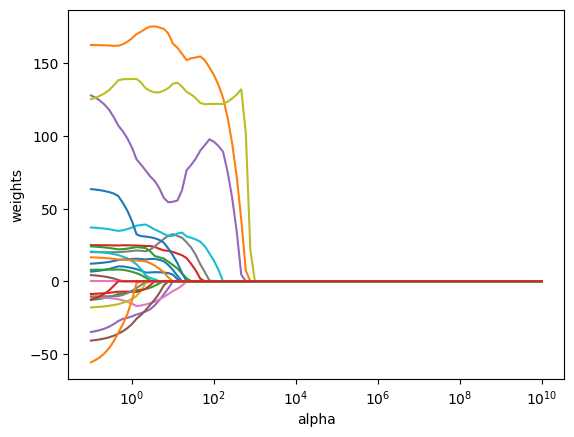

In [241]:
lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train_scaled), Y_train)
    coefs.append(lasso.coef_)

print(len(coefs))

# Graficamos los valores de alpha
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')

In [242]:
# Elegimos el mejor o el valor más óptimo de alpha por Cv
lassocv = LassoCV(alphas = None, cv = 10, max_iter = 100000)
lassocv.fit(X_train_scaled, Y_train)
print('best_alpha: ',lassocv.alpha_)

lasso = Lasso(alpha=lassocv.alpha_ ,max_iter = 10000)
lasso.fit(X_train_scaled, Y_train)

best_alpha:  5.399495804019429


Lasso(alpha=5.399495804019429, max_iter=10000)

In [243]:
# Obtenemos las predicciones
X_pred_lasso = lasso.predict(X_train_scaled)
Y_pred_lasso = lasso.predict(X_test_scaled)

In [244]:
# Obtenemos las funciones de coste
print ('Error cuadrático medio:')
print('Train:',mean_squared_error(Y_train, X_pred_lasso))
print('Test:',mean_squared_error(Y_test, Y_pred_lasso),'\n')

print ('Raiz Error cuadrático medio:')
print('Train:',np.sqrt(mean_squared_error(Y_train, X_pred_lasso)))
print('Test:',np.sqrt(mean_squared_error(Y_test, Y_pred_lasso)),'\n')

print ('R cuadrado:')
print('Train:',r2_score(Y_train, X_pred_lasso))
print('Test:',r2_score(Y_test, Y_pred_lasso))

Error cuadrático medio:
Train: 3043.9313779155977
Test: 6287.145145260388 

Raiz Error cuadrático medio:
Train: 55.17183500587594
Test: 79.29152000851282 

R cuadrado:
Train: 0.9827432777167314
Test: 0.9346346278689767


In [268]:
print(pd.Series(lasso.coef_, index = X.columns))

Peso_VERDES_propios                           3.670567
Peso_MADUROS_propios                        162.582243
Peso_SMADUROS_propios                        -0.000000
Peso_ESCOBAJO_propios                        19.802359
Peso_MALFORMADOA_propios                     -0.000000
Peso_MALFORMADOB_propios                     -0.000000
Peso_VERDES_terceros                         -6.291730
Peso_MADUROS_terceros                        32.117188
Peso_SMADUROS_terceros                       -0.000000
Peso_ESCOBAJO_terceros                        0.000000
Peso_MALFORMADO_terceros                      6.687949
PRECIPITACION_TOTAL_rolling_2_SHIFTED_24      0.000000
SALDO > 2                                    10.531522
SALDO > 3                                    -0.000000
TM PERDIDA TOTAL                             54.986009
TM ACEITE CONDENSADO                         -0.000000
TM ACEITE ESCOBAJO                            0.000000
TM ACEITE RACIMO MAL DESFRUTADO               0.000000
TM ACEITE 

##### 4.4. Random Forest

In [245]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

In [246]:
# Separar las características (X) y la variable objetivo (y)
X = df_model.drop("CPOObtenido",axis=1) # covariables
Y = df_model['CPOObtenido'] # target

In [248]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=20)


In [249]:
# Entrenar el modelo de Random Forest
ran_forest = RandomForestRegressor(random_state=20)
ran_forest.fit(X_train, y_train)

RandomForestRegressor(random_state=20)

In [250]:
# Predicciones
y_train_pred = ran_forest.predict(X_train)
y_test_pred = ran_forest.predict(X_test)

In [251]:
# Evaluar el modelo
print(f"R2 en el conjunto de entrenamiento: {r2_score(y_train, y_train_pred)}")
print(f"R2 en el conjunto de prueba: {r2_score(y_test, y_test_pred)}")

R2 en el conjunto de entrenamiento: 0.9929202265458389
R2 en el conjunto de prueba: 0.9388458337561739


Optimizamos los hiperparametros del random forest

In [252]:
# Definir los parámetros que deseas ajustar
param_grid = {
    'n_estimators': [100, 200, 300],       # Número de árboles en el bosque
    'max_depth': [10, 20, 30, None],       # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],       # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4],         # Número mínimo de muestras por hoja
    'max_features': ['auto', 'sqrt', 'log2']  # Número de características a considerar en cada división
}

# Configurar el GridSearch
grid_search = GridSearchCV(estimator = ran_forest, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='r2')

In [253]:
#  Ejecutar el GridSearch
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


c:\Users\CESAR QUEZADA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
341 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\CESAR QUEZADA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\CESAR QUEZADA\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\CESAR QUEZADA\AppData\Local\Programs\Python\Python3

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=20), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, None],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='r2', verbose=2)

In [254]:
# Imprimir los mejores parámetros encontrados
print(f"Mejores parámetros encontrados: {grid_search.best_params_}")


Mejores parámetros encontrados: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [255]:
# Obtener el mejor modelo
best_model_rand_forest = grid_search.best_estimator_

In [256]:
# Predicciones
y_train_pred_gs = best_model_rand_forest.predict(X_train)
y_test_pred_gs = best_model_rand_forest.predict(X_test)

In [257]:
# Evaluar el modelo
print(f"R2 en el conjunto de entrenamiento: {r2_score(y_train, y_train_pred_gs)}")
print(f"R2 en el conjunto de prueba: {r2_score(y_test, y_test_pred_gs)}")

R2 en el conjunto de entrenamiento: 0.9882010704210741
R2 en el conjunto de prueba: 0.8934405373302223


##### 4.5. Cross Validation

In [169]:
from sklearn.model_selection import cross_val_score

In [258]:
# Validación cruzada
scores = cross_val_score(best_model_rand_forest, X_train, y_train, cv=5, scoring='r2')
# scores = cross_val_score(lasso, X_train, y_train, cv=5, scoring='r2')
print(f"R2 Promedio con Validación Cruzada: {scores.mean()}")

R2 Promedio con Validación Cruzada: 0.8951132648796823


In [259]:
# Mostrando los 5 valores de R^2 obtenidos
print("Valores de R^2 en cada fold de la validación cruzada:")
for i, score in enumerate(scores, 1):
    print(f"Fold {i}: {score:.4f}")

Valores de R^2 en cada fold de la validación cruzada:
Fold 1: 0.7779
Fold 2: 0.9249
Fold 3: 0.9127
Fold 4: 0.9413
Fold 5: 0.9188


### 6. Evaluando las feature_importances

In [260]:
# Obtener importancia de las variables
importancias = best_model_rand_forest.feature_importances_
variables = X.columns

# Crear un DataFrame con las importancias
importancia_df = pd.DataFrame({'Variable': variables, 'Importancia': importancias})
importancia_df = importancia_df.sort_values(by='Importancia', ascending=False)
importancia_df.head(20)

,Variable,Importancia
18,TM ACEITE FIBRA,0.181238
14,TM PERDIDA TOTAL,0.143401
16,TM ACEITE ESCOBAJO,0.128204
1,Peso_MADUROS_propios,0.122556
19,TM ACEITE AGUA TD,0.086923
22,mes,0.062596
15,TM ACEITE CONDENSADO,0.043531
23,semana,0.036127
4,Peso_MALFORMADOA_propios,0.026297
20,TM ACEITE CASCARA,0.025515


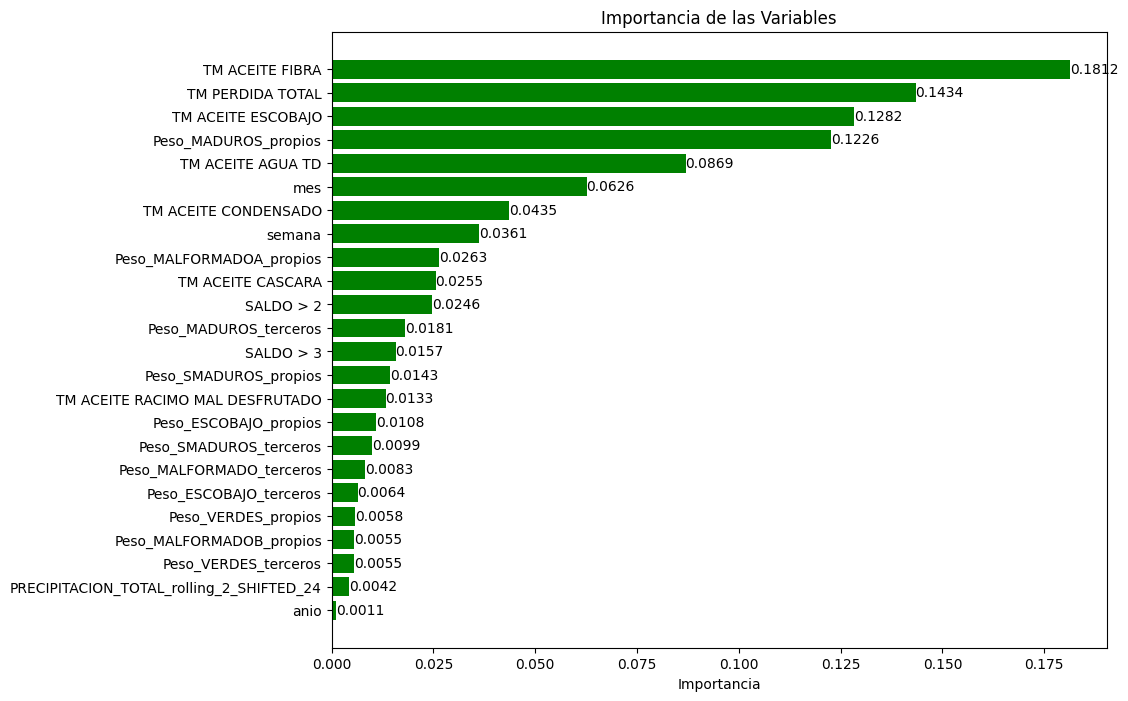

In [261]:
# Ordenar las características por importancia
feature_importances = importancia_df.sort_values(by='Importancia', ascending=True)

# Generar el gráfico de barras horizontales
plt.figure(figsize=(10, 8))
bars = plt.barh(feature_importances['Variable'], feature_importances['Importancia'], color='green')

# Añadir los valores de importancia al final de cada barra
for bar in bars:
    plt.text(
        bar.get_width(),               # Coordenada X donde se coloca el texto (al final de la barra)
        bar.get_y() + bar.get_height()/2,  # Coordenada Y donde se coloca el texto (centro de la barra)
        f'{bar.get_width():.4f}',      # Texto que se muestra (valor de importancia)
        va='center'                    # Alineación vertical del texto (centrado)
    )

plt.xlabel('Importancia')
plt.title('Importancia de las Variables')
plt.show()


### 3. Guardando el mejor modelo

In [ ]:
#Gracias!